# Efficient Binding Affinity Prediction via Lightweight Cross-Attention Fusion of ESM2 Protein Embeddings and Ligand Fingerprints

In [6]:
import pandas as pd
import numpy as np
from bioservices import UniProt
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from rdkit import DataStructs
import ast
from transformers import EsmModel, EsmTokenizer
import random
import warnings
warnings.filterwarnings("ignore")

# Obtain Protein Sequences from BindingDB

In [7]:
binding_db = pd.read_csv(
    "BindingDB_All.tsv", 
    sep="\t",
    on_bad_lines='skip',  # Skip rows with incorrect number of fields
    low_memory=False      # Prevent dtype warnings
)

# Print dataset info to verify loading
print(f"Loaded {len(binding_db)} rows")
print("\nColumns:")
print(binding_db.columns.tolist())

Loaded 2991143 rows

Columns:
['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI', 'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI', 'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number', 'Authors', 'Institution', 'Link to Ligand in BindingDB', 'Link to Target in BindingDB', 'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB', 'PDB ID(s) for Ligand-Target Complex', 'PubChem CID', 'PubChem SID', 'ChEBI ID of Ligand', 'ChEMBL ID of Ligand', 'DrugBank ID of Ligand', 'IUPHAR_GRAC ID of Ligand', 'KEGG ID of Ligand', 'ZINC ID of Ligand', 'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain', 'UniProt (SwissProt) Recommended Name of Target Chain', 'UniProt 

In [8]:
"""
# Extract unique UniProt IDs
uniprot_ids = set(binding_db["UniProt (SwissProt) Primary ID of Target Chain"].dropna().unique())

print(len(uniprot_ids))

# Initialize UniProt API
u = UniProt()

# Fetch sequences
protein_sequences = {}
for uid in uniprot_ids:
    print(uid)

    result = u.search(uid, columns="sequence", frmt="tsv")
    lines = result.split("\n")
    if len(lines) > 1:  # Ensure valid sequence exists
        protein_sequences[uid] = lines[1]

# Convert to DataFrame
protein_seq_df = pd.DataFrame(protein_sequences.items(), columns=["UniProt_ID", "Sequence"])
"""

'\n# Extract unique UniProt IDs\nuniprot_ids = set(binding_db["UniProt (SwissProt) Primary ID of Target Chain"].dropna().unique())\n\nprint(len(uniprot_ids))\n\n# Initialize UniProt API\nu = UniProt()\n\n# Fetch sequences\nprotein_sequences = {}\nfor uid in uniprot_ids:\n    print(uid)\n\n    result = u.search(uid, columns="sequence", frmt="tsv")\n    lines = result.split("\n")\n    if len(lines) > 1:  # Ensure valid sequence exists\n        protein_sequences[uid] = lines[1]\n\n# Convert to DataFrame\nprotein_seq_df = pd.DataFrame(protein_sequences.items(), columns=["UniProt_ID", "Sequence"])\n'

In [9]:
protein_seq_df = pd.read_csv("protein_sequences.tsv", sep="\t")

In [10]:
print(f"🔢 Original rows: {len(binding_db)}")

# Kd conversion
binding_db["Kd (nM)"] = pd.to_numeric(binding_db["Kd (nM)"], errors="coerce")
binding_db = binding_db.dropna(subset=["Kd (nM)"])
print(f"✅ After Kd filtering: {len(binding_db)}")

# pKd
binding_db["pKd"] = 9 - np.log10(binding_db["Kd (nM)"])

# SMILES validity
binding_db["Ligand SMILES"] = binding_db["Ligand SMILES"].astype(str)

invalid_smiles_count = 0
def smiles_to_fp(smiles):
    global invalid_smiles_count
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    else:
        invalid_smiles_count += 1
        return None

tqdm.pandas()
binding_db["Fingerprint"] = binding_db["Ligand SMILES"].progress_apply(smiles_to_fp)
print(f"✅ After SMILES: {len(binding_db)} — Dropped {invalid_smiles_count} invalid SMILES")

binding_db = binding_db[binding_db["Fingerprint"].notnull()]
print(f"✅ After removing NULL fingerprints: {len(binding_db)}")

🔢 Original rows: 2991143
✅ After Kd filtering: 69437


  0%|          | 0/69437 [00:00<?, ?it/s][15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPRECATION WARNING: please use MorganGenerator
[15:56:33] DEPR

✅ After SMILES: 69437 — Dropped 21 invalid SMILES
✅ After removing NULL fingerprints: 69416


In [13]:
print(f"🧬 Unique UniProt IDs in binding_db: {binding_db['UniProt (SwissProt) Primary ID of Target Chain'].nunique()}")
print(f"🧬 Unique UniProt IDs with sequences: {protein_seq_df['UniProt_ID'].nunique()}")

🧬 Unique UniProt IDs in binding_db: 1817
🧬 Unique UniProt IDs with sequences: 6644


In [14]:
# Standardize UniProt ID column name in BindingDB
binding_db = binding_db.copy()

# Prefer SwissProt ID; fallback to TrEMBL if needed
binding_db["UniProt_ID"] = binding_db["UniProt (SwissProt) Primary ID of Target Chain"]
fallback_ids = binding_db["UniProt (TrEMBL) Primary ID of Target Chain"]

# Fill missing UniProt_IDs from TrEMBL when SwissProt is missing
binding_db["UniProt_ID"] = binding_db["UniProt_ID"].fillna(fallback_ids)

# Drop entries with missing UniProt_IDs
binding_db = binding_db.dropna(subset=["UniProt_ID"])

# Merge with protein sequences
merged_df = pd.merge(binding_db , protein_seq_df, on="UniProt_ID", how="inner")

# Keep only the useful columns
merged_df = merged_df[["UniProt_ID", "Ligand SMILES", "Fingerprint", "pKd", "Sequence"]]

# Drop missing values in critical columns
merged_df = merged_df.dropna(subset=["Ligand SMILES", "Fingerprint", "pKd", "Sequence"]).reset_index(drop=True)

# Show result
print(f"✅ Final merged_df shape: {merged_df.shape}")
display(merged_df.head())

✅ Final merged_df shape: (67610, 5)


UniProt_ID                        Ligand SMILES  \
0     Q873X9  CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
1     Q873X9  CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
2     Q873X9  CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
3     Q873X9  CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
4     Q873X9  CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   

                                         Fingerprint       pKd  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.366532   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.113509   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.000000   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.207608   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.346787   

                                            Sequence  
0  MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
1  MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
2  MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
3  MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
4  MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...

In [15]:
merged_df

UniProt_ID                                      Ligand SMILES  \
0         Q873X9                CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
1         Q873X9                CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
2         Q873X9                CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
3         Q873X9                CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
4         Q873X9                CC(=O)CCCCn1c(=O)n(C)c2ncn(C)c2c1=O   
...          ...                                                ...   
67605     P0DTD1  CC(C)[C@]1(O)C(OC(=O)c2ccc[nH]2)[C@@]2(O)[C@@]...   
67606     P0DTD1  CC1(C)CC[C@H](O)[C@]23CO[C@@](O)([C@@H](O)[C@H...   
67607     Q8NG06     CN(C)CCCNc1nc(NCC2CCNCC2)c2cc(ccc2n1)-c1ccccc1   
67608     Q13191  O=C(NC1N=C(c2ccccc2)c2ccccc2NC1=O)c1ccccc1CN1C...   
67609     Q13191  C[C@H]1C[C@](C1)(c1nncn1C)c1cccc(c1)N1Cc2c(cc(...   

                                             Fingerprint       pKd  \
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.366532   
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.113509   
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.000000   
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.207608   
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.346787   
...                                                  ...       ...   
67605  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  4.318307   
67606  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  5.142668   
67607  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.619789   
67608  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  6.397940   
67609  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  8.522879   

                                                Sequence  
0      MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
1      MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
2      MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
3      MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
4      MRFATSTIVKVALLLSSLCVDAAVMWNRDTSSTDLEARASSGYRSV...  
...                                                  ...  
67605  MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...  
67606  MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...  
67607  MAWAPPGERLREDARCPVCLDFLQEPVSVDCGHSFCLRCISEFCEK...  
67608  MANSMNGRNPGGRGGNPRKGRILGIIDAIQDAVGPPKQAAADRRTV...  
67609  MANSMNGRNPGGRGGNPRKGRILGIIDAIQDAVGPPKQAAADRRTV...  

[67610 rows x 5 columns]

In [16]:
# 1. Rename columns if needed
test_data = merged_df.copy()
test_data = test_data.rename(columns={
    'Ligand SMILES': 'SMILES'  # Rename to match required column names
})

# 2. Ensure we have all required columns
required_cols = ['UniProt_ID', 'SMILES', 'Sequence', 'Fingerprint', 'pKd']
missing_cols = [col for col in required_cols if col not in test_data.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")

# 3. Ensure correct data types
# Convert fingerprints to proper format if they're stored as strings
if test_data['Fingerprint'].dtype == 'object':
    # Check if fingerprints are stored as string representations of lists
    if isinstance(test_data['Fingerprint'].iloc[0], str):
        # Convert string representations to actual numpy arrays
        import ast
        test_data['Fingerprint'] = test_data['Fingerprint'].apply(
            lambda x: str(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else str(x)
        )

# Ensure pKd is float
test_data['pKd'] = test_data['pKd'].astype(float)

# Ensure Sequence and SMILES are strings
test_data['Sequence'] = test_data['Sequence'].astype(str)
test_data['SMILES'] = test_data['SMILES'].astype(str)

# 4. Select only the required columns
test_data = test_data[required_cols]

# 5. Save to disk
test_data.to_csv('test_data.csv', index=False)

print(f"✅ Saved test data with {len(test_data)} rows and {len(test_data.columns)} columns")
print(f"Columns: {test_data.columns.tolist()}")
print(f"Data types: {test_data.dtypes}")

✅ Saved test data with 67610 rows and 5 columns
Columns: ['UniProt_ID', 'SMILES', 'Sequence', 'Fingerprint', 'pKd']
Data types: UniProt_ID      object
SMILES          object
Sequence        object
Fingerprint     object
pKd            float64
dtype: object


In [ ]:
import pandas as pd
import numpy as np
from rdkit import DataStructs
import re

# Load test data
test_data = pd.read_csv('test_data.csv')

# Check the format of the fingerprints
print("Original fingerprint format:", test_data['Fingerprint'].iloc[0][:100])

# Function to convert RDKit fingerprint string representation to array
def convert_rdkit_fp_str(fp_str):
    # If it's already in the format [0, 1, 0, ...] just return it
    if fp_str.startswith('[') and fp_str.endswith(']'):
        # Extract the numbers
        return fp_str
    
    # If it's an RDKit object reference, we need to create a dummy array
    if '<rdkit.DataStructs.cDataStructs.ExplicitBitVect' in fp_str:
        # Create a dummy fingerprint of 2048 zeros (you might need to adjust the size)
        return '[' + ','.join(['0']*2048) + ']'
    
    # Return original if we can't process it
    return fp_str

# Apply the conversion to the fingerprints
test_data['Fingerprint'] = test_data['Fingerprint'].apply(convert_rdkit_fp_str)

# Save the modified data
test_data.to_csv('test_data_fixed.csv', index=False)
print("Saved fixed test data with processed fingerprints")

Original fingerprint format: <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x00000212FACACC10>
Saved fixed test data with processed fingerprints


# Training

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import EsmTokenizer, EsmModel
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.cuda.amp import autocast, GradScaler
import sys
from itertools import islice
from lifelines.utils import concordance_index
from entmax import sparsemax

# --------------------------
# ✅ Config - Optimized for visualization
# --------------------------
SEED = 42
BATCH_SIZE = 4  # Increased for better batch statistics
TOTAL_EPOCHS = 1
LR = 1e-4  # Slightly increased for faster convergence
MAX_SEQ_LEN = 512
UNFREEZE_LAST_N_LAYERS = 2  # Increased for better protein representation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRINT_EVERY = 50
LIGAND_NUM_TOKENS = 32  # Increased from 8 to allow finer-grained fingerprint resolution
EMBED_DIM = 256  # Reduced from 512 to decrease model size

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# --------------------------
# ✅ Dataset Class
# --------------------------
class BindingAffinityDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_seq_len=384):
        self.df = df
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row['Sequence']
        
        # Extract binding site if available (otherwise use full sequence)
        if 'BindingSite' in row and not pd.isna(row['BindingSite']):
            sequence = row['BindingSite']
            
        # Tokenize protein sequence
        tokenized = self.tokenizer(
            sequence, 
            max_length=self.max_seq_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Remove batch dimension
        tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
        
        # Convert fingerprint string to numpy array
        fp_str = row['Fingerprint']
        if isinstance(fp_str, str):
            # Handle string representation like '[0, 0, 1, ...]'
            fp_str = fp_str.strip('[]')
            # Explicitly convert to float32 to avoid double precision
            fp = np.array([float(x.strip()) for x in fp_str.split(',')], dtype=np.float32)
        else:
            # Handle if it's already a list or array
            fp = np.array(fp_str, dtype=np.float32)
            
        # Ensure tensor is float32
        fp = torch.tensor(fp, dtype=torch.float32)
        
        # Store protein ID and ligand SMILES for visualization
        metadata = {
            'ProteinID': row.get('UniProt_ID', str(idx)),
            'LigandSMILES': row.get('Ligand SMILES', 'Unknown'),
            'Sequence': sequence
        }
        
        # Ensure pkd is float32
        pkd = float(row['pKd'])
        pkd = torch.tensor(pkd, dtype=torch.float32)
        
        return tokenized, fp, pkd, metadata

# --------------------------
# ✅ Enhanced Cross-Attention Fusion
# --------------------------
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=8, attn_dropout=0.05, residual_scale=1.5):
        super().__init__()
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=attn_dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.residual_scale = residual_scale
        
        # Adaptive gate mechanism
        self.gate = nn.Sequential(
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()
        )
        
        # Add a small FFN for better feature transformations
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim * 2, embed_dim),
            nn.Dropout(0.1)
        )

    def forward(self, query, key_value, return_attn=False, return_raw_attn=False):
        # Store original query for residual
        identity = query
        
        # LayerNorm applied before attention, following transformer conventions
        query_norm = self.norm1(query)
        
        # Projections
        Q = self.query_proj(query_norm)
        K = self.key_proj(key_value)
        V = self.value_proj(key_value)
        
        # Multi-head attention
        attn_output, attn_weights = self.attn(Q, K, V, need_weights=True, average_attn_weights=False)
        
        # Calculate dynamic gate value based on content
        gate_value = self.gate(attn_output.mean(dim=1, keepdim=True))
        
        # Apply residual connection with dynamic gating
        attn_output = identity + gate_value * self.residual_scale * attn_output
        
        # Second LayerNorm + FFN
        ffn_input = self.norm2(attn_output)
        ffn_output = self.ffn(ffn_input)
        
        # Final residual connection
        output = attn_output + ffn_output
        
        # Return needed outputs
        if return_raw_attn:
            return output, attn_weights  # Return raw attention weights without detaching
        if return_attn:
            return output, attn_weights.detach().cpu()
        return output

# --------------------------
# ✅ Optimized Model Architecture
# --------------------------
class DeepBindAffinityModel(nn.Module):
    def __init__(self, esm_model, fp_dim=2048, embed_dim=EMBED_DIM, ligand_tokens=LIGAND_NUM_TOKENS):
        super().__init__()
        self.esm = esm_model
        self.T_ligand = ligand_tokens
        self.embed_dim = embed_dim
        self.fp_dim = fp_dim
        self.esm_dim = esm_model.config.hidden_size
        
        # Layer to project fingerprint into multiple token embeddings
        self.fp_proj = nn.Sequential(
            nn.Linear(self.fp_dim, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, self.T_ligand * self.embed_dim),
        )
        
        # Convolutional feature extraction from protein sequence
        self.cnn = nn.Sequential(
            nn.Conv1d(self.esm_dim, self.embed_dim * 2, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv1d(self.embed_dim * 2, self.embed_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Dropout(0.1),
        )
        
        # Cross-attention between protein and ligand
        self.cross_attention_prot2lig = CrossAttentionFusion(embed_dim=self.embed_dim)
        self.cross_attention_lig2prot = CrossAttentionFusion(embed_dim=self.embed_dim)
        
        # Final regressor with bottleneck
        self.regressor = nn.Sequential(
            nn.Linear(self.embed_dim * 2, self.embed_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self.embed_dim, self.embed_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(self.embed_dim // 2, 1),
        )
        
        # Additional projection for visualization
        self.vis_proj = nn.Linear(self.embed_dim, 1)

    def forward(self, tokenized_seq, ligand_fp, return_attention=False):
        tokenized_seq = {k: v.to(DEVICE) for k, v in tokenized_seq.items()}
        batch_size = ligand_fp.shape[0]

        # ESM forward pass
        with autocast():
            esm_output = self.esm(**tokenized_seq)

        # Process protein embeddings
        seq_embeddings = esm_output.last_hidden_state                      # (B, L, H)
        seq_features = self.cnn(seq_embeddings.transpose(1, 2))            # (B, D, L)
        protein_emb = seq_features.transpose(1, 2)                         # (B, L, D)

        # Process ligand fingerprint
        ligand_proj = self.fp_proj(ligand_fp.to(DEVICE))                   # (B, T×D)
        ligand_emb = ligand_proj.view(batch_size, self.T_ligand, self.embed_dim)  # (B, T, D)

        # Bidirectional attention
        if return_attention:
            # Get raw attention without detaching for visualization
            attn_output1, attn_weights1 = self.cross_attention_prot2lig(
                query=protein_emb, key_value=ligand_emb, return_raw_attn=True
            )
            attn_output2, attn_weights2 = self.cross_attention_lig2prot(
                query=ligand_emb, key_value=protein_emb, return_raw_attn=True
            )
        else:
            # Normal forward pass
            attn_output1, attn_weights1 = self.cross_attention_prot2lig(
                query=protein_emb, key_value=ligand_emb, return_attn=True
            )
            attn_output2, attn_weights2 = self.cross_attention_lig2prot(
                query=ligand_emb, key_value=protein_emb, return_attn=True
            )

        # Sparsemax for sharper, more interpretable attention
        # Average over heads and apply sparsemax for each sequence position
        attn_weights1_sparse = []
        attn_weights2_sparse = []
        
        # Apply sparsemax to get sparser attention weights (for better visualization)
        for b in range(batch_size):
            # For each head in protein->ligand attention
            head_attns1 = []
            for h in range(attn_weights1.shape[1]):  # num_heads
                head_attns1.append(sparsemax(attn_weights1[b, h], dim=-1))
            attn_weights1_sparse.append(torch.stack(head_attns1))
            
            # For each head in ligand->protein attention
            head_attns2 = []
            for h in range(attn_weights2.shape[1]):  # num_heads
                head_attns2.append(sparsemax(attn_weights2[b, h], dim=-1))
            attn_weights2_sparse.append(torch.stack(head_attns2))
            
        attn_weights1_sparse = torch.stack(attn_weights1_sparse)
        attn_weights2_sparse = torch.stack(attn_weights2_sparse)

        # Protein -> Ligand summarization (weighted average)
        attn_weights1_avg = attn_weights1_sparse.mean(dim=1).mean(dim=-1, keepdim=True).transpose(1, 2)  # (B, 1, L)
        # Ensure device alignment
        attn_weights1_avg = attn_weights1_avg.to(attn_output1.device)
        summary1 = torch.bmm(attn_weights1_avg, attn_output1).squeeze(1)  # (B, D)

        # Ligand -> Protein summarization (weighted average)
        attn_weights2_avg = attn_weights2_sparse.mean(dim=1).mean(dim=-1, keepdim=True).transpose(1, 2)  # (B, 1, T)
        # Ensure device alignment
        attn_weights2_avg = attn_weights2_avg.to(attn_output2.device)
        summary2 = torch.bmm(attn_weights2_avg, attn_output2).squeeze(1)  # (B, D)

        # Feature fusion
        fusion = torch.cat([summary1, summary2], dim=-1)  # (B, 2D)
        
        # Final prediction
        binding_affinity = self.regressor(fusion).squeeze(-1)
        
        if return_attention:
            # For visualization, return a tuple of:
            # 1. Predicted binding affinity
            # 2. Protein -> Ligand attention (for identifying important residues)
            # 3. Ligand -> Protein attention (for identifying important ligand substructures)
            # 4. Protein embeddings after attention
            # 5. Ligand embeddings after attention
            return (
                binding_affinity,
                attn_weights1_sparse,  # Protein -> Ligand attention
                attn_weights2_sparse,  # Ligand -> Protein attention
                attn_output1,          # Protein embeddings after cross-attention
                attn_output2,          # Ligand embeddings after cross-attention
            )
        
        return binding_affinity

# --------------------------
# ✅ Model Initialization
# --------------------------
def initialize_model():
    # Load ESM model and tokenizer
    esm_model_name = "facebook/esm2_t6_8M_UR50D"  # Smaller ESM model
    tokenizer = EsmTokenizer.from_pretrained(esm_model_name)
    esm_model = EsmModel.from_pretrained(esm_model_name)
    
    # Freeze most ESM layers, only unfreeze the last N layers
    for param in esm_model.parameters():
        param.requires_grad = False
    
    # Unfreeze only the last N layers
    for layer in esm_model.encoder.layer[-UNFREEZE_LAST_N_LAYERS:]:
        for param in layer.parameters():
            param.requires_grad = True
    
    esm_model.to(DEVICE)
    esm_model.eval()  # Keep in eval mode even during training
    
    # Create our model
    model = DeepBindAffinityModel(esm_model, embed_dim=EMBED_DIM).to(DEVICE)
    
    return model, tokenizer

# --------------------------
# ✅ Attention Visualization Utilities
# --------------------------
def visualize_attention(model, dataloader, tokenizer, sample_idx=0, save_path=None, 
                       attention_threshold=0.2):
    """
    Visualize attention weights between protein and ligand, showing labels only for
    high attention values.
    
    Args:
        model: Trained model
        dataloader: DataLoader containing samples
        tokenizer: ESM tokenizer for decoding tokens
        sample_idx: Index of sample to visualize
        save_path: Path to save visualization
        attention_threshold: Threshold for highlighting high attention values (0-1)
    """
    model.eval()
    
    # Get a batch
    for i, (tokenized_seq, ligand_fp, pkd, metadata) in enumerate(dataloader):
        if i == sample_idx // dataloader.batch_size:
            idx_in_batch = sample_idx % dataloader.batch_size
            if idx_in_batch >= len(tokenized_seq['input_ids']):
                print(f"Sample index {sample_idx} exceeds batch size {len(tokenized_seq['input_ids'])}")
                return
            
            # Get single sample
            tokens = {k: v[idx_in_batch:idx_in_batch+1] for k, v in tokenized_seq.items()}
            fp = ligand_fp[idx_in_batch:idx_in_batch+1]
            pkd_value = pkd[idx_in_batch].item()
            meta = {k: v[idx_in_batch] for k, v in metadata.items()}
            
            # Forward pass with attention
            with torch.no_grad():
                outputs = model(tokens, fp, return_attention=True)
                pred_pkd, prot2lig_attn, lig2prot_attn, prot_emb, lig_emb = outputs
            
            # Decode protein sequence tokens
            token_ids = tokens['input_ids'][0].cpu().numpy()
            protein_tokens = tokenizer.convert_ids_to_tokens(token_ids)
            
            # Extract attention weights (average across heads)
            prot2lig_attn = prot2lig_attn[0].mean(dim=0).cpu().numpy()  # (L, T)
            lig2prot_attn = lig2prot_attn[0].mean(dim=0).cpu().numpy()  # (T, L)
            
            # Filter out padding tokens
            attention_mask = tokens['attention_mask'][0].cpu().numpy()
            valid_tokens = attention_mask.astype(bool)
            valid_protein_tokens = [t for t, m in zip(protein_tokens, valid_tokens) if m]
            valid_prot2lig_attn = prot2lig_attn[valid_tokens, :]
            
            # Find residue positions (ignoring special tokens)
            residue_positions = []
            residue_labels = []
            for i, token in enumerate(valid_protein_tokens):
                if token.startswith("EMBL_") or token in ("<cls>", "<pad>", "<eos>", "<unk>", "<mask>"):
                    continue
                residue_positions.append(i)
                residue_labels.append(token)
            
            # Create a new attention matrix with just residues
            residue_attn = valid_prot2lig_attn[residue_positions, :]
            
            # Create ligand substructure labels (hypothetical fragments)
            ligand_labels = [f"Frag_{i+1}" for i in range(model.T_ligand)]
            
            # 1. Determine which residues have high attention for any ligand fragment
            # For each residue (row), find its maximum attention value across all fragments
            residue_max_attention = residue_attn.max(axis=1)
            high_attention_residue_indices = np.where(residue_max_attention > attention_threshold)[0]
            
            # Create selective labels for residues (only show labels for high attention residues)
            selective_residue_labels = []
            for i in range(len(residue_labels)):
                if i in high_attention_residue_indices:
                    selective_residue_labels.append(residue_labels[i])
                else:
                    selective_residue_labels.append("")
            
            # Create figure with 2 subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 1]})
            
            # Plot 1: Protein -> Ligand attention (which ligand parts attend to which protein residues)
            sns.heatmap(residue_attn, ax=ax1, cmap="viridis", 
                        xticklabels=ligand_labels,
                        yticklabels=selective_residue_labels)
            ax1.set_title(f"Protein → Ligand Attention\nProtein: {meta['ProteinID']}, pKd: {pkd_value:.2f} (pred: {pred_pkd.item():.2f})")
            ax1.set_ylabel("Protein Residues")
            ax1.set_xlabel("Ligand Fragments")
            
            # 2. Plot ligand -> protein attention (which protein residues each ligand part attends to)
            valid_lig2prot_attn = lig2prot_attn[:, valid_tokens]
            frag_to_residue_attn = valid_lig2prot_attn[:, residue_positions]
            
            # For each fragment (row), find the residues with high attention
            frag_max_attention = frag_to_residue_attn.max(axis=0)  # Max attention per residue column
            high_attention_residue_cols = np.where(frag_max_attention > attention_threshold)[0]
            
            # Create selective labels for x-axis (residues)
            selective_residue_labels_x = []
            for i in range(len(residue_labels)):
                if i in high_attention_residue_cols:
                    selective_residue_labels_x.append(residue_labels[i])
                else:
                    selective_residue_labels_x.append("")
            
            sns.heatmap(frag_to_residue_attn, ax=ax2, cmap="rocket_r",
                        yticklabels=ligand_labels,
                        xticklabels=selective_residue_labels_x)
            ax2.set_title(f"Ligand → Protein Attention\nLigand: {meta['LigandSMILES'][:30]}...")
            ax2.set_ylabel("Ligand Fragments")
            ax2.set_xlabel("Protein Residues")
            
            # Add annotations for high attention areas
            for y in range(residue_attn.shape[0]):
                for x in range(residue_attn.shape[1]):
                    if residue_attn[y, x] > attention_threshold * 1.5:  # Higher threshold for annotations
                        ax1.text(x + 0.5, y + 0.5, f"{residue_labels[y]}", 
                                horizontalalignment='center', verticalalignment='center',
                                color='white' if residue_attn[y, x] > 0.6 else 'black',
                                fontsize=8, fontweight='bold')
            
            for y in range(frag_to_residue_attn.shape[0]):
                for x in range(frag_to_residue_attn.shape[1]):
                    if frag_to_residue_attn[y, x] > attention_threshold * 1.5:  # Higher threshold for annotations
                        ax2.text(x + 0.5, y + 0.5, f"{residue_labels[x]}", 
                                horizontalalignment='center', verticalalignment='center',
                                color='white' if frag_to_residue_attn[y, x] > 0.6 else 'black',
                                fontsize=8, fontweight='bold')
            
            plt.tight_layout()
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Visualization saved to {save_path}")
            else:
                plt.show()
            
            # Create an additional detailed view of only the highest attention interactions
            plt.figure(figsize=(16, 8))
            
            # Focus just on high attention residues for a clearer view
            high_attn_residue_indices = np.where(residue_max_attention > attention_threshold)[0]
            if len(high_attn_residue_indices) > 0:
                high_attn_residue_attn = residue_attn[high_attn_residue_indices]
                high_attn_residue_labels = [residue_labels[i] for i in high_attn_residue_indices]
                
                plt.subplot(1, 2, 1)
                sns.heatmap(high_attn_residue_attn, cmap="viridis", 
                           xticklabels=ligand_labels,
                           yticklabels=high_attn_residue_labels)
                plt.title("High Attention Residues → Ligand")
                plt.ylabel("Protein Residues")
                plt.xlabel("Ligand Fragments")
                
                # Show top 5 highest attention residue-fragment pairs
                flat_indices = np.argsort(residue_attn.flatten())[-5:]
                row_indices, col_indices = np.unravel_index(flat_indices, residue_attn.shape)
                
                attention_table = [["Residue", "Fragment", "Attention"]]
                for row, col in zip(row_indices, col_indices):
                    attention_table.append([
                        residue_labels[row], 
                        f"Frag_{col+1}", 
                        f"{residue_attn[row, col]:.4f}"
                    ])
                
                plt.subplot(1, 2, 2)
                plt.axis('off')
                plt.table(cellText=attention_table[1:], colLabels=attention_table[0], 
                         loc='center', cellLoc='center')
                plt.title("Top 5 Residue-Fragment Interactions")
                
                if save_path:
                    detailed_path = save_path.replace('.png', '_detailed.png')
                    plt.savefig(detailed_path, dpi=300, bbox_inches='tight')
                    print(f"Detailed visualization saved to {detailed_path}")
                else:
                    plt.show()
            
            break

# --------------------------
# ✅ Training Function
# --------------------------

def train_model(model, train_loader, val_loader, num_epochs=1, lr=LR, print_every=PRINT_EVERY):
    # Define loss function
    loss_fn = nn.MSELoss()
    
    # Separate LR for pretrained model vs new parameters
    esm_params = []
    other_params = []
    for name, param in model.named_parameters():
        # Ensure all parameters are float32
        if param.dtype != torch.float32:
            param.data = param.data.to(torch.float32)
            
        if "esm" in name and param.requires_grad:
            esm_params.append(param)
        elif param.requires_grad:
            other_params.append(param)
    
    # Create optimizer with different learning rates
    optimizer = optim.AdamW([
        {"params": esm_params, "lr": lr * 0.1},
        {"params": other_params, "lr": lr}
    ], weight_decay=1e-3)
    
    # Create scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=len(train_loader) * num_epochs
    )
    
    # Gradient scaler for mixed precision
    scaler = GradScaler()
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ Model size: {total_params/1e6:.2f}M parameters ({trainable_params/1e6:.2f}M trainable)")
    
    # Training loop
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_losses = []
        
        # Training loop
        for batch_idx, (tokenized_seq, ligand_fp, pkd_true, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
            optimizer.zero_grad()
            
            # Move target to device and ensure it's float32
            pkd_true = pkd_true.to(DEVICE).clamp(0.0, 15.0)
            
            try:
                # Forward pass with mixed precision
                with autocast():
                    preds = model(tokenized_seq, ligand_fp)
                    preds = torch.clamp(preds, 0.0, 15.0)
                    loss = loss_fn(preds, pkd_true)
                
                # Skip bad batches
                if not torch.isfinite(loss): 
                    continue
                    
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Optimizer and scheduler steps
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                
                # Record loss
                epoch_losses.append(loss.item())
            
            except RuntimeError as e:
                if "expected Float but got Double" in str(e) or "Found dtype Double but expected Float" in str(e):
                    print(f"Precision error in batch {batch_idx}. Skipping...")
                    # Print shapes and dtypes for debugging
                    print(f"pkd_true dtype: {pkd_true.dtype}")
                    print(f"Model parameter dtypes: {[p.dtype for p in model.parameters()][:5]}")
                    continue
                else:
                    raise e
            
            # Periodic validation
            if (batch_idx + 1) % print_every == 0:
                val_metrics = validate(model, val_loader, loss_fn, max_batches=10)
                print(
                    f"Step {batch_idx+1}/{len(train_loader)} | "
                    f"Train loss: {loss.item():.4f} | "
                    f"Val loss: {val_metrics['loss']:.4f} | "
                    f"Pearson: {val_metrics['pearson']:.4f}"
                )
                model.train()
        
        # End of epoch validation
        val_metrics = validate(model, val_loader, loss_fn)
        
        # Record losses
        train_loss = np.mean(epoch_losses)
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        
        # Print metrics
        print(f"✅ Epoch {epoch}/{num_epochs} completed")
        print(f"📊 Train loss: {train_loss:.4f} | Val loss: {val_metrics['loss']:.4f}")
        print(f"📈 Pearson: {val_metrics['pearson']:.4f} | Spearman: {val_metrics['spearman']:.4f}")
        print(f"📏 MAE: {val_metrics['mae']:.4f} | MSE: {val_metrics['mse']:.4f} | R²: {val_metrics['r2']:.4f}")
        
        # Save best model
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'metrics': val_metrics
            }, "best_binding_model.pt")
            print("📂 Saved best model checkpoint")
    
    return train_losses, val_losses
def validate(model, dataloader, loss_fn, max_batches=None):
    """Validate model on dataloader"""
    model.eval()
    
    losses = []
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (tokenized_seq, ligand_fp, pkd_true, _) in enumerate(dataloader):
            if max_batches and batch_idx >= max_batches:
                break
                
            # Move to device and ensure float32
            pkd_true = pkd_true.to(DEVICE).clamp(0.0, 15.0)
            
            try:
                # Forward pass
                with autocast():
                    preds = model(tokenized_seq, ligand_fp)
                    preds = torch.clamp(preds, 0.0, 15.0)
                    loss = loss_fn(preds, pkd_true)
                
                # Record results if valid
                if torch.isfinite(loss):
                    losses.append(loss.item())
                    y_true.extend(pkd_true.cpu().numpy().tolist())
                    y_pred.extend(preds.cpu().numpy().tolist())
            
            except RuntimeError as e:
                if "expected Float but got Double" in str(e) or "Found dtype Double but expected Float" in str(e):
                    print(f"Precision error in validation batch {batch_idx}. Skipping...")
                    continue
                else:
                    raise e
    
    # Calculate metrics
    if not y_true or not y_pred:
        return {
            'loss': float('nan'),
            'pearson': float('nan'),
            'spearman': float('nan'),
            'mae': float('nan'),
            'mse': float('nan'),
            'r2': float('nan'),
            'ci': float('nan')
        }
    
    metrics = {
        'loss': np.mean(losses) if losses else float('nan'),
        'pearson': pearsonr(y_true, y_pred)[0] if len(y_true) > 1 else float('nan'),
        'spearman': spearmanr(y_true, y_pred)[0] if len(y_true) > 1 else float('nan'),
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'ci': concordance_index(y_true, y_pred)
    }
    
    return metrics

# Function to check and fix model precision
def fix_model_precision(model):
    """Convert all model parameters to float32"""
    for name, param in model.named_parameters():
        if param.dtype != torch.float32:
            print(f"Converting {name} from {param.dtype} to float32")
            param.data = param.data.to(torch.float32)
    return model

# Function to check and fix dataset precision issues
def check_dataloader_precision(dataloader):
    """Check precision of data from dataloader"""
    for batch in dataloader:
        tokenized_seq, ligand_fp, pkd_true, _ = batch
        print(f"Fingerprint dtype: {ligand_fp.dtype}")
        print(f"pkd_true dtype: {pkd_true.dtype}")
        
        # If double precision found, check data type in first few samples
        if pkd_true.dtype == torch.float64:
            print("Warning: Found double precision in pkd values")
            for i in range(min(5, len(pkd_true))):
                print(f"Sample {i} pkd value: {pkd_true[i].item()}, type: {type(pkd_true[i].item())}")
        break

# Evaluation

In [52]:
# Data preprocessing
print("🔄 Preparing data...")
merged_df = merged_df.dropna(subset=["pKd"]).copy()

# Convert pKd column to float32 to avoid precision issues
merged_df["pKd"] = merged_df["pKd"].astype(np.float32).clip(0.0, 15.0)

# Create stratification bins
try:
    merged_df["pKd_bin"] = pd.qcut(merged_df["pKd"], q=10, duplicates="drop")
except ValueError:
    merged_df["pKd_bin"] = pd.qcut(merged_df["pKd"], q=5, duplicates="drop")

# Split data
train_df, val_df = train_test_split(
    merged_df, test_size=0.1, stratify=merged_df["pKd_bin"], random_state=42
)

# Cleanup
for df in [train_df, val_df]:
    if "pKd_bin" in df.columns:
        df.drop(columns=["pKd_bin"], inplace=True)

# Initialize model
print("🔄 Initializing model...")
model, tokenizer = initialize_model()

# Force model parameters to float32
model = fix_model_precision(model)

# Create datasets and dataloaders
print("🔄 Creating dataloaders...")
train_ds = BindingAffinityDataset(train_df, tokenizer)
val_ds = BindingAffinityDataset(val_df, tokenizer)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=0, pin_memory=False
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    num_workers=0, pin_memory=False
)

# Check dataloader precision
print("🔄 Checking dataloader precision...")
check_dataloader_precision(train_loader)

# Train model
print("🚀 Starting training...")
train_losses, val_losses = train_model(
    model, train_loader, val_loader, 
    num_epochs=TOTAL_EPOCHS
)

🔄 Preparing data...
🔄 Initializing model...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 Creating dataloaders...
🔄 Checking dataloader precision...
Fingerprint dtype: torch.float32
pkd_true dtype: torch.float32
🚀 Starting training...
✅ Model size: 15.59M parameters (10.22M trainable)


Epoch 1:   0%|          | 50/15213 [00:24<5:32:02,  1.31s/it]

Step 50/15213 | Train loss: 4.9099 | Val loss: 2.8939 | Pearson: 0.1822


Epoch 1:   1%|          | 100/15213 [00:48<5:31:03,  1.31s/it]

Step 100/15213 | Train loss: 2.2789 | Val loss: 2.4077 | Pearson: 0.2552


Epoch 1:   1%|          | 150/15213 [01:12<5:07:00,  1.22s/it]

Step 150/15213 | Train loss: 0.6033 | Val loss: 2.0373 | Pearson: 0.5012


Epoch 1:   1%|▏         | 200/15213 [01:36<5:30:31,  1.32s/it]

Step 200/15213 | Train loss: 4.2525 | Val loss: 2.0468 | Pearson: 0.4882


Epoch 1:   2%|▏         | 250/15213 [02:01<5:48:48,  1.40s/it]

Step 250/15213 | Train loss: 5.0430 | Val loss: 2.3183 | Pearson: 0.5121


Epoch 1:   2%|▏         | 300/15213 [02:25<5:18:42,  1.28s/it]

Step 300/15213 | Train loss: 2.0317 | Val loss: 3.0814 | Pearson: 0.5430


Epoch 1:   2%|▏         | 350/15213 [02:49<5:17:32,  1.28s/it]

Step 350/15213 | Train loss: 0.1905 | Val loss: 2.1823 | Pearson: 0.5154


Epoch 1:   3%|▎         | 400/15213 [03:13<5:22:27,  1.31s/it]

Step 400/15213 | Train loss: 4.0115 | Val loss: 2.0002 | Pearson: 0.5800


Epoch 1:   3%|▎         | 450/15213 [03:38<5:23:20,  1.31s/it]

Step 450/15213 | Train loss: 2.7731 | Val loss: 2.4762 | Pearson: 0.5744


Epoch 1:   3%|▎         | 500/15213 [04:02<5:22:57,  1.32s/it]

Step 500/15213 | Train loss: 2.2883 | Val loss: 3.0183 | Pearson: 0.5871


Epoch 1:   4%|▎         | 550/15213 [04:27<5:20:49,  1.31s/it]

Step 550/15213 | Train loss: 2.6026 | Val loss: 1.5911 | Pearson: 0.6191


Epoch 1:   4%|▍         | 600/15213 [04:51<5:22:45,  1.33s/it]

Step 600/15213 | Train loss: 6.9285 | Val loss: 2.0930 | Pearson: 0.5605


Epoch 1:   4%|▍         | 650/15213 [05:16<5:20:54,  1.32s/it]

Step 650/15213 | Train loss: 1.4401 | Val loss: 3.0731 | Pearson: 0.5521


Epoch 1:   5%|▍         | 700/15213 [05:40<5:17:32,  1.31s/it]

Step 700/15213 | Train loss: 1.4843 | Val loss: 2.0014 | Pearson: 0.6152


Epoch 1:   5%|▍         | 750/15213 [06:05<5:19:23,  1.32s/it]

Step 750/15213 | Train loss: 0.3300 | Val loss: 2.0924 | Pearson: 0.6044


Epoch 1:   5%|▌         | 800/15213 [06:29<5:16:25,  1.32s/it]

Step 800/15213 | Train loss: 3.2729 | Val loss: 1.7903 | Pearson: 0.6099


Epoch 1:   6%|▌         | 850/15213 [06:54<5:14:40,  1.31s/it]

Step 850/15213 | Train loss: 6.7253 | Val loss: 1.7848 | Pearson: 0.5951


Epoch 1:   6%|▌         | 900/15213 [07:18<5:14:59,  1.32s/it]

Step 900/15213 | Train loss: 2.2459 | Val loss: 1.8404 | Pearson: 0.5401


Epoch 1:   6%|▌         | 950/15213 [07:43<5:13:30,  1.32s/it]

Step 950/15213 | Train loss: 3.2345 | Val loss: 1.7907 | Pearson: 0.5466


Epoch 1:   7%|▋         | 1000/15213 [08:07<5:14:17,  1.33s/it]

Step 1000/15213 | Train loss: 1.4075 | Val loss: 1.7482 | Pearson: 0.5602


Epoch 1:   7%|▋         | 1050/15213 [08:32<5:02:25,  1.28s/it]

Step 1050/15213 | Train loss: 3.6529 | Val loss: 1.8660 | Pearson: 0.5796


Epoch 1:   7%|▋         | 1100/15213 [08:56<5:02:24,  1.29s/it]

Step 1100/15213 | Train loss: 3.4779 | Val loss: 1.5153 | Pearson: 0.6437


Epoch 1:   8%|▊         | 1150/15213 [09:19<5:00:37,  1.28s/it]

Step 1150/15213 | Train loss: 4.1956 | Val loss: 2.0339 | Pearson: 0.5786


Epoch 1:   8%|▊         | 1200/15213 [09:43<4:58:27,  1.28s/it]

Step 1200/15213 | Train loss: 1.8554 | Val loss: 1.7509 | Pearson: 0.5778


Epoch 1:   8%|▊         | 1250/15213 [10:07<4:59:22,  1.29s/it]

Step 1250/15213 | Train loss: 1.3256 | Val loss: 2.1478 | Pearson: 0.5994


Epoch 1:   9%|▊         | 1300/15213 [10:31<5:07:43,  1.33s/it]

Step 1300/15213 | Train loss: 4.1361 | Val loss: 1.7743 | Pearson: 0.5895


Epoch 1:   9%|▉         | 1350/15213 [10:56<5:06:28,  1.33s/it]

Step 1350/15213 | Train loss: 4.7848 | Val loss: 1.8842 | Pearson: 0.5897


Epoch 1:   9%|▉         | 1400/15213 [11:20<5:04:35,  1.32s/it]

Step 1400/15213 | Train loss: 3.7777 | Val loss: 1.7261 | Pearson: 0.5912


Epoch 1:  10%|▉         | 1450/15213 [11:45<5:04:10,  1.33s/it]

Step 1450/15213 | Train loss: 3.3967 | Val loss: 1.9042 | Pearson: 0.5973


Epoch 1:  10%|▉         | 1500/15213 [12:09<5:02:23,  1.32s/it]

Step 1500/15213 | Train loss: 9.4687 | Val loss: 1.7705 | Pearson: 0.5883


Epoch 1:  10%|█         | 1550/15213 [12:34<5:00:32,  1.32s/it]

Step 1550/15213 | Train loss: 1.3738 | Val loss: 1.7404 | Pearson: 0.5896


Epoch 1:  11%|█         | 1600/15213 [12:58<4:59:04,  1.32s/it]

Step 1600/15213 | Train loss: 4.0398 | Val loss: 1.6988 | Pearson: 0.6098


Epoch 1:  11%|█         | 1650/15213 [13:23<4:58:46,  1.32s/it]

Step 1650/15213 | Train loss: 2.3081 | Val loss: 1.5498 | Pearson: 0.6372


Epoch 1:  11%|█         | 1700/15213 [13:47<4:56:49,  1.32s/it]

Step 1700/15213 | Train loss: 2.6720 | Val loss: 1.5326 | Pearson: 0.6442


Epoch 1:  12%|█▏        | 1750/15213 [14:12<4:58:00,  1.33s/it]

Step 1750/15213 | Train loss: 0.4812 | Val loss: 1.8911 | Pearson: 0.5748


Epoch 1:  12%|█▏        | 1800/15213 [14:37<4:54:44,  1.32s/it]

Step 1800/15213 | Train loss: 7.9066 | Val loss: 1.8086 | Pearson: 0.5799


Epoch 1:  12%|█▏        | 1850/15213 [15:01<4:53:51,  1.32s/it]

Step 1850/15213 | Train loss: 0.4408 | Val loss: 1.6990 | Pearson: 0.5896


Epoch 1:  12%|█▏        | 1900/15213 [15:26<4:51:33,  1.31s/it]

Step 1900/15213 | Train loss: 5.2142 | Val loss: 1.8070 | Pearson: 0.5702


Epoch 1:  13%|█▎        | 1950/15213 [15:50<4:53:36,  1.33s/it]

Step 1950/15213 | Train loss: 0.5554 | Val loss: 1.9527 | Pearson: 0.5451


Epoch 1:  13%|█▎        | 2000/15213 [16:15<4:51:28,  1.32s/it]

Step 2000/15213 | Train loss: 4.0456 | Val loss: 2.9065 | Pearson: 0.5866


Epoch 1:  13%|█▎        | 2050/15213 [16:39<4:47:36,  1.31s/it]

Step 2050/15213 | Train loss: 6.9399 | Val loss: 1.6080 | Pearson: 0.6080


Epoch 1:  14%|█▍        | 2100/15213 [17:04<4:48:19,  1.32s/it]

Step 2100/15213 | Train loss: 2.1924 | Val loss: 1.7165 | Pearson: 0.6272


Epoch 1:  14%|█▍        | 2150/15213 [17:28<4:46:09,  1.31s/it]

Step 2150/15213 | Train loss: 2.8963 | Val loss: 1.6810 | Pearson: 0.6086


Epoch 1:  14%|█▍        | 2200/15213 [17:53<4:45:55,  1.32s/it]

Step 2200/15213 | Train loss: 0.7638 | Val loss: 1.7848 | Pearson: 0.6113


Epoch 1:  15%|█▍        | 2250/15213 [18:17<4:45:04,  1.32s/it]

Step 2250/15213 | Train loss: 5.1223 | Val loss: 1.6381 | Pearson: 0.6079


Epoch 1:  15%|█▌        | 2300/15213 [18:42<4:43:05,  1.32s/it]

Step 2300/15213 | Train loss: 1.0686 | Val loss: 1.6686 | Pearson: 0.6202


Epoch 1:  15%|█▌        | 2350/15213 [19:06<4:35:52,  1.29s/it]

Step 2350/15213 | Train loss: 0.4055 | Val loss: 2.0582 | Pearson: 0.6424


Epoch 1:  16%|█▌        | 2400/15213 [19:30<4:33:36,  1.28s/it]

Step 2400/15213 | Train loss: 5.2455 | Val loss: 1.5562 | Pearson: 0.6492


Epoch 1:  16%|█▌        | 2450/15213 [19:54<4:33:49,  1.29s/it]

Step 2450/15213 | Train loss: 1.2571 | Val loss: 1.5540 | Pearson: 0.6320


Epoch 1:  16%|█▋        | 2500/15213 [20:17<4:31:03,  1.28s/it]

Step 2500/15213 | Train loss: 1.9862 | Val loss: 1.6028 | Pearson: 0.6263


Epoch 1:  17%|█▋        | 2550/15213 [20:41<4:29:47,  1.28s/it]

Step 2550/15213 | Train loss: 5.3456 | Val loss: 1.6618 | Pearson: 0.5882


Epoch 1:  17%|█▋        | 2600/15213 [21:05<4:34:25,  1.31s/it]

Step 2600/15213 | Train loss: 1.3865 | Val loss: 1.7892 | Pearson: 0.5605


Epoch 1:  17%|█▋        | 2650/15213 [21:29<4:33:15,  1.31s/it]

Step 2650/15213 | Train loss: 3.8496 | Val loss: 1.9117 | Pearson: 0.5738


Epoch 1:  18%|█▊        | 2700/15213 [21:54<4:34:54,  1.32s/it]

Step 2700/15213 | Train loss: 0.9365 | Val loss: 1.7528 | Pearson: 0.5760


Epoch 1:  18%|█▊        | 2750/15213 [22:18<4:30:14,  1.30s/it]

Step 2750/15213 | Train loss: 6.0178 | Val loss: 1.7924 | Pearson: 0.5796


Epoch 1:  18%|█▊        | 2800/15213 [22:43<4:32:46,  1.32s/it]

Step 2800/15213 | Train loss: 0.3900 | Val loss: 2.3972 | Pearson: 0.5916


Epoch 1:  19%|█▊        | 2850/15213 [23:07<4:31:19,  1.32s/it]

Step 2850/15213 | Train loss: 0.5657 | Val loss: 1.6499 | Pearson: 0.5934


Epoch 1:  19%|█▉        | 2900/15213 [23:32<4:29:56,  1.32s/it]

Step 2900/15213 | Train loss: 3.5023 | Val loss: 1.6527 | Pearson: 0.5917


Epoch 1:  19%|█▉        | 2950/15213 [23:56<4:27:32,  1.31s/it]

Step 2950/15213 | Train loss: 2.9388 | Val loss: 1.8519 | Pearson: 0.5724


Epoch 1:  20%|█▉        | 3000/15213 [24:20<4:26:43,  1.31s/it]

Step 3000/15213 | Train loss: 3.2473 | Val loss: 1.8147 | Pearson: 0.6046


Epoch 1:  20%|██        | 3050/15213 [24:45<4:25:59,  1.31s/it]

Step 3050/15213 | Train loss: 0.6393 | Val loss: 1.8799 | Pearson: 0.5673


Epoch 1:  20%|██        | 3100/15213 [25:09<4:25:43,  1.32s/it]

Step 3100/15213 | Train loss: 1.0853 | Val loss: 2.0213 | Pearson: 0.5743


Epoch 1:  21%|██        | 3150/15213 [25:34<4:23:36,  1.31s/it]

Step 3150/15213 | Train loss: 0.3804 | Val loss: 1.7425 | Pearson: 0.5769


Epoch 1:  21%|██        | 3200/15213 [25:58<4:26:40,  1.33s/it]

Step 3200/15213 | Train loss: 2.1371 | Val loss: 1.9838 | Pearson: 0.5839


Epoch 1:  21%|██▏       | 3250/15213 [26:23<4:23:17,  1.32s/it]

Step 3250/15213 | Train loss: 1.6982 | Val loss: 1.6897 | Pearson: 0.5833


Epoch 1:  22%|██▏       | 3300/15213 [26:47<4:19:47,  1.31s/it]

Step 3300/15213 | Train loss: 0.5234 | Val loss: 1.8440 | Pearson: 0.5847


Epoch 1:  22%|██▏       | 3350/15213 [27:11<4:22:04,  1.33s/it]

Step 3350/15213 | Train loss: 7.7597 | Val loss: 1.7140 | Pearson: 0.5861


Epoch 1:  22%|██▏       | 3400/15213 [27:36<4:19:29,  1.32s/it]

Step 3400/15213 | Train loss: 1.0828 | Val loss: 1.7120 | Pearson: 0.5778


Epoch 1:  23%|██▎       | 3450/15213 [28:00<4:18:37,  1.32s/it]

Step 3450/15213 | Train loss: 1.0491 | Val loss: 1.8553 | Pearson: 0.5688


Epoch 1:  23%|██▎       | 3500/15213 [28:25<4:16:03,  1.31s/it]

Step 3500/15213 | Train loss: 0.4060 | Val loss: 2.1326 | Pearson: 0.5321


Epoch 1:  23%|██▎       | 3550/15213 [28:49<4:17:32,  1.32s/it]

Step 3550/15213 | Train loss: 1.8535 | Val loss: 1.8695 | Pearson: 0.5592


Epoch 1:  24%|██▎       | 3600/15213 [29:14<4:16:08,  1.32s/it]

Step 3600/15213 | Train loss: 0.3901 | Val loss: 1.7893 | Pearson: 0.5773


Epoch 1:  24%|██▍       | 3650/15213 [29:38<4:10:27,  1.30s/it]

Step 3650/15213 | Train loss: 1.5389 | Val loss: 1.6021 | Pearson: 0.6141


Epoch 1:  24%|██▍       | 3700/15213 [30:02<4:05:32,  1.28s/it]

Step 3700/15213 | Train loss: 1.9201 | Val loss: 1.5877 | Pearson: 0.6275


Epoch 1:  25%|██▍       | 3750/15213 [30:26<4:03:14,  1.27s/it]

Step 3750/15213 | Train loss: 0.2652 | Val loss: 1.7495 | Pearson: 0.6140


Epoch 1:  25%|██▍       | 3800/15213 [30:50<4:03:43,  1.28s/it]

Step 3800/15213 | Train loss: 2.0376 | Val loss: 2.4510 | Pearson: 0.5689


Epoch 1:  25%|██▌       | 3850/15213 [31:13<4:01:57,  1.28s/it]

Step 3850/15213 | Train loss: 0.8979 | Val loss: 2.1425 | Pearson: 0.5768


Epoch 1:  26%|██▌       | 3900/15213 [31:37<4:03:49,  1.29s/it]

Step 3900/15213 | Train loss: 1.6656 | Val loss: 1.7634 | Pearson: 0.5640


Epoch 1:  26%|██▌       | 3950/15213 [32:02<4:07:14,  1.32s/it]

Step 3950/15213 | Train loss: 0.5796 | Val loss: 1.6291 | Pearson: 0.5990


Epoch 1:  26%|██▋       | 4000/15213 [32:26<4:05:46,  1.32s/it]

Step 4000/15213 | Train loss: 0.5902 | Val loss: 1.7878 | Pearson: 0.5700


Epoch 1:  27%|██▋       | 4050/15213 [32:51<4:03:45,  1.31s/it]

Step 4050/15213 | Train loss: 1.3268 | Val loss: 1.6499 | Pearson: 0.5968


Epoch 1:  27%|██▋       | 4100/15213 [33:15<4:03:45,  1.32s/it]

Step 4100/15213 | Train loss: 2.4633 | Val loss: 1.9191 | Pearson: 0.5840


Epoch 1:  27%|██▋       | 4150/15213 [33:40<4:00:34,  1.30s/it]

Step 4150/15213 | Train loss: 3.9181 | Val loss: 1.6371 | Pearson: 0.6085


Epoch 1:  28%|██▊       | 4200/15213 [34:05<4:09:00,  1.36s/it]

Step 4200/15213 | Train loss: 1.2713 | Val loss: 1.8582 | Pearson: 0.6187


Epoch 1:  28%|██▊       | 4250/15213 [34:29<3:59:32,  1.31s/it]

Step 4250/15213 | Train loss: 2.0790 | Val loss: 1.6568 | Pearson: 0.6009


Epoch 1:  28%|██▊       | 4300/15213 [34:54<3:58:32,  1.31s/it]

Step 4300/15213 | Train loss: 2.1522 | Val loss: 1.8326 | Pearson: 0.6226


Epoch 1:  29%|██▊       | 4350/15213 [35:18<3:57:56,  1.31s/it]

Step 4350/15213 | Train loss: 1.6307 | Val loss: 1.6570 | Pearson: 0.6206


Epoch 1:  29%|██▉       | 4400/15213 [35:43<3:55:06,  1.30s/it]

Step 4400/15213 | Train loss: 1.3379 | Val loss: 1.8155 | Pearson: 0.6022


Epoch 1:  29%|██▉       | 4450/15213 [36:07<3:55:04,  1.31s/it]

Step 4450/15213 | Train loss: 0.8485 | Val loss: 1.6638 | Pearson: 0.6423


Epoch 1:  30%|██▉       | 4500/15213 [36:31<3:52:53,  1.30s/it]

Step 4500/15213 | Train loss: 0.6474 | Val loss: 1.6068 | Pearson: 0.6327


Epoch 1:  30%|██▉       | 4550/15213 [36:56<3:53:29,  1.31s/it]

Step 4550/15213 | Train loss: 0.3305 | Val loss: 1.7662 | Pearson: 0.6206


Epoch 1:  30%|███       | 4600/15213 [37:20<3:52:59,  1.32s/it]

Step 4600/15213 | Train loss: 3.0079 | Val loss: 1.4685 | Pearson: 0.6496


Epoch 1:  31%|███       | 4650/15213 [37:45<3:50:43,  1.31s/it]

Step 4650/15213 | Train loss: 1.6248 | Val loss: 1.4929 | Pearson: 0.6430


Epoch 1:  31%|███       | 4700/15213 [38:09<3:50:16,  1.31s/it]

Step 4700/15213 | Train loss: 6.8126 | Val loss: 1.7320 | Pearson: 0.6415


Epoch 1:  31%|███       | 4750/15213 [38:34<3:50:40,  1.32s/it]

Step 4750/15213 | Train loss: 2.1542 | Val loss: 1.4033 | Pearson: 0.6774


Epoch 1:  32%|███▏      | 4800/15213 [38:58<3:47:53,  1.31s/it]

Step 4800/15213 | Train loss: 0.7168 | Val loss: 1.3704 | Pearson: 0.6812


Epoch 1:  32%|███▏      | 4850/15213 [39:23<3:48:39,  1.32s/it]

Step 4850/15213 | Train loss: 1.7065 | Val loss: 1.6074 | Pearson: 0.6844


Epoch 1:  32%|███▏      | 4900/15213 [39:47<3:44:38,  1.31s/it]

Step 4900/15213 | Train loss: 1.9154 | Val loss: 1.3640 | Pearson: 0.6856


Epoch 1:  33%|███▎      | 4950/15213 [40:12<3:40:19,  1.29s/it]

Step 4950/15213 | Train loss: 7.9136 | Val loss: 1.3755 | Pearson: 0.6906


Epoch 1:  33%|███▎      | 5000/15213 [40:35<3:37:49,  1.28s/it]

Step 5000/15213 | Train loss: 5.8487 | Val loss: 1.4766 | Pearson: 0.6903


Epoch 1:  33%|███▎      | 5050/15213 [40:59<3:37:43,  1.29s/it]

Step 5050/15213 | Train loss: 1.1209 | Val loss: 1.3099 | Pearson: 0.6978


Epoch 1:  34%|███▎      | 5100/15213 [41:23<3:35:08,  1.28s/it]

Step 5100/15213 | Train loss: 1.4744 | Val loss: 1.4918 | Pearson: 0.6719


Epoch 1:  34%|███▍      | 5150/15213 [41:47<3:35:56,  1.29s/it]

Step 5150/15213 | Train loss: 2.4745 | Val loss: 1.4595 | Pearson: 0.6534


Epoch 1:  34%|███▍      | 5200/15213 [42:11<3:33:06,  1.28s/it]

Step 5200/15213 | Train loss: 0.8396 | Val loss: 1.5878 | Pearson: 0.6784


Epoch 1:  35%|███▍      | 5250/15213 [42:35<3:40:19,  1.33s/it]

Step 5250/15213 | Train loss: 1.9541 | Val loss: 1.5876 | Pearson: 0.6524


Epoch 1:  35%|███▍      | 5300/15213 [43:00<3:37:02,  1.31s/it]

Step 5300/15213 | Train loss: 0.8078 | Val loss: 1.5975 | Pearson: 0.6591


Epoch 1:  35%|███▌      | 5350/15213 [43:24<3:35:59,  1.31s/it]

Step 5350/15213 | Train loss: 0.3770 | Val loss: 1.5752 | Pearson: 0.6629


Epoch 1:  35%|███▌      | 5400/15213 [43:49<3:34:15,  1.31s/it]

Step 5400/15213 | Train loss: 0.4170 | Val loss: 1.4521 | Pearson: 0.6563


Epoch 1:  36%|███▌      | 5450/15213 [44:14<3:33:42,  1.31s/it]

Step 5450/15213 | Train loss: 1.2646 | Val loss: 1.5118 | Pearson: 0.6421


Epoch 1:  36%|███▌      | 5500/15213 [44:38<3:34:06,  1.32s/it]

Step 5500/15213 | Train loss: 1.7202 | Val loss: 1.8398 | Pearson: 0.6393


Epoch 1:  36%|███▋      | 5550/15213 [45:03<3:32:16,  1.32s/it]

Step 5550/15213 | Train loss: 6.4955 | Val loss: 1.5147 | Pearson: 0.6451


Epoch 1:  37%|███▋      | 5600/15213 [45:27<3:31:21,  1.32s/it]

Step 5600/15213 | Train loss: 0.8811 | Val loss: 1.6685 | Pearson: 0.6304


Epoch 1:  37%|███▋      | 5650/15213 [45:52<3:28:24,  1.31s/it]

Step 5650/15213 | Train loss: 5.0811 | Val loss: 1.5900 | Pearson: 0.6230


Epoch 1:  37%|███▋      | 5700/15213 [46:16<3:28:19,  1.31s/it]

Step 5700/15213 | Train loss: 4.2966 | Val loss: 1.5747 | Pearson: 0.6399


Epoch 1:  38%|███▊      | 5750/15213 [46:41<3:25:43,  1.30s/it]

Step 5750/15213 | Train loss: 0.2254 | Val loss: 1.4193 | Pearson: 0.6713


Epoch 1:  38%|███▊      | 5800/15213 [47:05<3:25:51,  1.31s/it]

Step 5800/15213 | Train loss: 0.5571 | Val loss: 1.8485 | Pearson: 0.6492


Epoch 1:  38%|███▊      | 5850/15213 [47:29<3:24:16,  1.31s/it]

Step 5850/15213 | Train loss: 0.6967 | Val loss: 1.4098 | Pearson: 0.6722


Epoch 1:  39%|███▉      | 5900/15213 [47:54<3:22:43,  1.31s/it]

Step 5900/15213 | Train loss: 0.1418 | Val loss: 1.5314 | Pearson: 0.6607


Epoch 1:  39%|███▉      | 5950/15213 [48:18<3:21:19,  1.30s/it]

Step 5950/15213 | Train loss: 2.1387 | Val loss: 1.5858 | Pearson: 0.6495


Epoch 1:  39%|███▉      | 6000/15213 [48:43<3:20:51,  1.31s/it]

Step 6000/15213 | Train loss: 1.4286 | Val loss: 1.7973 | Pearson: 0.6533


Epoch 1:  40%|███▉      | 6050/15213 [49:07<3:19:45,  1.31s/it]

Step 6050/15213 | Train loss: 1.6216 | Val loss: 1.6304 | Pearson: 0.6413


Epoch 1:  40%|████      | 6100/15213 [49:31<3:18:25,  1.31s/it]

Step 6100/15213 | Train loss: 1.7808 | Val loss: 1.5132 | Pearson: 0.6392


Epoch 1:  40%|████      | 6150/15213 [49:56<3:17:02,  1.30s/it]

Step 6150/15213 | Train loss: 3.5978 | Val loss: 1.7217 | Pearson: 0.6465


Epoch 1:  41%|████      | 6200/15213 [50:20<3:17:02,  1.31s/it]

Step 6200/15213 | Train loss: 0.6952 | Val loss: 1.4212 | Pearson: 0.6680


Epoch 1:  41%|████      | 6250/15213 [50:44<3:12:20,  1.29s/it]

Step 6250/15213 | Train loss: 1.1466 | Val loss: 1.5427 | Pearson: 0.6767


Epoch 1:  41%|████▏     | 6300/15213 [51:08<3:12:12,  1.29s/it]

Step 6300/15213 | Train loss: 0.4937 | Val loss: 1.4412 | Pearson: 0.6632


Epoch 1:  42%|████▏     | 6350/15213 [51:32<3:07:22,  1.27s/it]

Step 6350/15213 | Train loss: 1.8302 | Val loss: 1.6700 | Pearson: 0.6624


Epoch 1:  42%|████▏     | 6400/15213 [51:56<3:08:21,  1.28s/it]

Step 6400/15213 | Train loss: 2.0342 | Val loss: 1.8583 | Pearson: 0.6747


Epoch 1:  42%|████▏     | 6450/15213 [52:20<3:06:29,  1.28s/it]

Step 6450/15213 | Train loss: 0.5783 | Val loss: 1.4198 | Pearson: 0.6686


Epoch 1:  43%|████▎     | 6500/15213 [52:43<3:05:04,  1.27s/it]

Step 6500/15213 | Train loss: 6.0890 | Val loss: 1.5453 | Pearson: 0.6642


Epoch 1:  43%|████▎     | 6550/15213 [53:08<3:08:43,  1.31s/it]

Step 6550/15213 | Train loss: 3.1456 | Val loss: 1.6027 | Pearson: 0.6402


Epoch 1:  43%|████▎     | 6600/15213 [53:32<3:10:05,  1.32s/it]

Step 6600/15213 | Train loss: 0.3470 | Val loss: 1.4980 | Pearson: 0.6432


Epoch 1:  44%|████▎     | 6650/15213 [53:57<3:06:47,  1.31s/it]

Step 6650/15213 | Train loss: 1.6123 | Val loss: 1.5687 | Pearson: 0.6316


Epoch 1:  44%|████▍     | 6700/15213 [54:21<3:04:39,  1.30s/it]

Step 6700/15213 | Train loss: 3.6971 | Val loss: 1.5504 | Pearson: 0.6481


Epoch 1:  44%|████▍     | 6750/15213 [54:46<3:05:21,  1.31s/it]

Step 6750/15213 | Train loss: 4.3508 | Val loss: 2.0896 | Pearson: 0.6703


Epoch 1:  45%|████▍     | 6800/15213 [55:10<3:02:38,  1.30s/it]

Step 6800/15213 | Train loss: 0.4616 | Val loss: 1.5684 | Pearson: 0.6499


Epoch 1:  45%|████▌     | 6850/15213 [55:35<3:02:57,  1.31s/it]

Step 6850/15213 | Train loss: 0.6911 | Val loss: 1.5483 | Pearson: 0.6398


Epoch 1:  45%|████▌     | 6900/15213 [55:59<3:01:05,  1.31s/it]

Step 6900/15213 | Train loss: 1.9737 | Val loss: 1.5370 | Pearson: 0.6304


Epoch 1:  46%|████▌     | 6950/15213 [56:23<3:00:41,  1.31s/it]

Step 6950/15213 | Train loss: 0.9664 | Val loss: 1.7024 | Pearson: 0.6141


Epoch 1:  46%|████▌     | 7000/15213 [56:48<2:59:39,  1.31s/it]

Step 7000/15213 | Train loss: 6.8198 | Val loss: 1.6661 | Pearson: 0.6209


Epoch 1:  46%|████▋     | 7050/15213 [57:12<2:57:25,  1.30s/it]

Step 7050/15213 | Train loss: 2.6383 | Val loss: 1.5053 | Pearson: 0.6450


Epoch 1:  47%|████▋     | 7100/15213 [57:37<2:58:39,  1.32s/it]

Step 7100/15213 | Train loss: 2.7796 | Val loss: 1.4509 | Pearson: 0.6576


Epoch 1:  47%|████▋     | 7150/15213 [58:01<2:57:17,  1.32s/it]

Step 7150/15213 | Train loss: 4.4772 | Val loss: 1.7584 | Pearson: 0.6491


Epoch 1:  47%|████▋     | 7200/15213 [58:25<2:56:19,  1.32s/it]

Step 7200/15213 | Train loss: 1.4892 | Val loss: 1.5251 | Pearson: 0.6363


Epoch 1:  48%|████▊     | 7250/15213 [58:50<2:54:15,  1.31s/it]

Step 7250/15213 | Train loss: 0.2650 | Val loss: 1.6517 | Pearson: 0.6517


Epoch 1:  48%|████▊     | 7300/15213 [59:14<2:55:51,  1.33s/it]

Step 7300/15213 | Train loss: 2.1570 | Val loss: 1.7668 | Pearson: 0.6483


Epoch 1:  48%|████▊     | 7350/15213 [59:39<2:52:38,  1.32s/it]

Step 7350/15213 | Train loss: 0.8146 | Val loss: 1.5233 | Pearson: 0.6600


Epoch 1:  49%|████▊     | 7400/15213 [1:00:03<2:51:34,  1.32s/it]

Step 7400/15213 | Train loss: 0.5209 | Val loss: 1.4714 | Pearson: 0.6623


Epoch 1:  49%|████▉     | 7450/15213 [1:00:28<2:51:20,  1.32s/it]

Step 7450/15213 | Train loss: 1.9930 | Val loss: 1.4363 | Pearson: 0.6689


Epoch 1:  49%|████▉     | 7500/15213 [1:00:52<2:50:19,  1.32s/it]

Step 7500/15213 | Train loss: 1.0607 | Val loss: 1.3970 | Pearson: 0.6711


Epoch 1:  50%|████▉     | 7550/15213 [1:01:17<2:43:42,  1.28s/it]

Step 7550/15213 | Train loss: 0.0869 | Val loss: 1.4479 | Pearson: 0.6581


Epoch 1:  50%|████▉     | 7600/15213 [1:01:41<2:42:47,  1.28s/it]

Step 7600/15213 | Train loss: 6.6626 | Val loss: 1.5914 | Pearson: 0.6423


Epoch 1:  50%|█████     | 7650/15213 [1:02:04<2:42:00,  1.29s/it]

Step 7650/15213 | Train loss: 1.7306 | Val loss: 1.4808 | Pearson: 0.6540


Epoch 1:  51%|█████     | 7700/15213 [1:02:28<2:41:13,  1.29s/it]

Step 7700/15213 | Train loss: 0.2243 | Val loss: 1.4942 | Pearson: 0.6542


Epoch 1:  51%|█████     | 7750/15213 [1:02:52<2:38:45,  1.28s/it]

Step 7750/15213 | Train loss: 1.2094 | Val loss: 1.4736 | Pearson: 0.6539


Epoch 1:  51%|█████▏    | 7800/15213 [1:03:16<2:37:54,  1.28s/it]

Step 7800/15213 | Train loss: 29.2418 | Val loss: 1.5767 | Pearson: 0.6450


Epoch 1:  52%|█████▏    | 7850/15213 [1:03:40<2:41:39,  1.32s/it]

Step 7850/15213 | Train loss: 1.8540 | Val loss: 1.5628 | Pearson: 0.6632


Epoch 1:  52%|█████▏    | 7900/15213 [1:04:05<2:40:56,  1.32s/it]

Step 7900/15213 | Train loss: 3.8724 | Val loss: 1.4717 | Pearson: 0.6629


Epoch 1:  52%|█████▏    | 7950/15213 [1:04:29<2:38:43,  1.31s/it]

Step 7950/15213 | Train loss: 2.1306 | Val loss: 1.4454 | Pearson: 0.6606


Epoch 1:  53%|█████▎    | 8000/15213 [1:04:54<2:39:50,  1.33s/it]

Step 8000/15213 | Train loss: 1.8584 | Val loss: 1.5483 | Pearson: 0.6503


Epoch 1:  53%|█████▎    | 8050/15213 [1:05:18<2:37:10,  1.32s/it]

Step 8050/15213 | Train loss: 2.4826 | Val loss: 1.5159 | Pearson: 0.6517


Epoch 1:  53%|█████▎    | 8100/15213 [1:05:43<2:35:49,  1.31s/it]

Step 8100/15213 | Train loss: 0.4671 | Val loss: 1.4711 | Pearson: 0.6564


Epoch 1:  54%|█████▎    | 8150/15213 [1:06:07<2:34:14,  1.31s/it]

Step 8150/15213 | Train loss: 1.1233 | Val loss: 1.5053 | Pearson: 0.6642


Epoch 1:  54%|█████▍    | 8200/15213 [1:06:31<2:33:25,  1.31s/it]

Step 8200/15213 | Train loss: 1.7103 | Val loss: 1.4618 | Pearson: 0.6540


Epoch 1:  54%|█████▍    | 8250/15213 [1:06:56<2:33:06,  1.32s/it]

Step 8250/15213 | Train loss: 0.9824 | Val loss: 1.4627 | Pearson: 0.6535


Epoch 1:  55%|█████▍    | 8300/15213 [1:07:20<2:31:34,  1.32s/it]

Step 8300/15213 | Train loss: 1.4168 | Val loss: 1.6401 | Pearson: 0.6550


Epoch 1:  55%|█████▍    | 8350/15213 [1:07:45<2:29:39,  1.31s/it]

Step 8350/15213 | Train loss: 2.0269 | Val loss: 1.4390 | Pearson: 0.6590


Epoch 1:  55%|█████▌    | 8400/15213 [1:08:09<2:29:08,  1.31s/it]

Step 8400/15213 | Train loss: 0.6317 | Val loss: 1.5294 | Pearson: 0.6654


Epoch 1:  56%|█████▌    | 8450/15213 [1:08:34<2:29:12,  1.32s/it]

Step 8450/15213 | Train loss: 4.4465 | Val loss: 1.4754 | Pearson: 0.6704


Epoch 1:  56%|█████▌    | 8500/15213 [1:08:58<2:28:34,  1.33s/it]

Step 8500/15213 | Train loss: 2.6941 | Val loss: 1.3896 | Pearson: 0.6855


Epoch 1:  56%|█████▌    | 8550/15213 [1:09:23<2:26:45,  1.32s/it]

Step 8550/15213 | Train loss: 1.3128 | Val loss: 1.4007 | Pearson: 0.6801


Epoch 1:  57%|█████▋    | 8600/15213 [1:09:48<2:25:11,  1.32s/it]

Step 8600/15213 | Train loss: 1.0583 | Val loss: 1.5183 | Pearson: 0.6677


Epoch 1:  57%|█████▋    | 8650/15213 [1:10:12<2:24:17,  1.32s/it]

Step 8650/15213 | Train loss: 7.2913 | Val loss: 1.3859 | Pearson: 0.6773


Epoch 1:  57%|█████▋    | 8700/15213 [1:10:36<2:22:05,  1.31s/it]

Step 8700/15213 | Train loss: 1.9942 | Val loss: 1.3719 | Pearson: 0.6869


Epoch 1:  58%|█████▊    | 8750/15213 [1:11:01<2:22:08,  1.32s/it]

Step 8750/15213 | Train loss: 0.2731 | Val loss: 1.3415 | Pearson: 0.6912


Epoch 1:  58%|█████▊    | 8800/15213 [1:11:25<2:20:22,  1.31s/it]

Step 8800/15213 | Train loss: 1.6675 | Val loss: 1.5654 | Pearson: 0.6814


Epoch 1:  58%|█████▊    | 8850/15213 [1:11:50<2:20:11,  1.32s/it]

Step 8850/15213 | Train loss: 2.7184 | Val loss: 1.3582 | Pearson: 0.6856


Epoch 1:  59%|█████▊    | 8900/15213 [1:12:14<2:14:33,  1.28s/it]

Step 8900/15213 | Train loss: 0.9311 | Val loss: 1.4148 | Pearson: 0.6698


Epoch 1:  59%|█████▉    | 8950/15213 [1:12:38<2:14:17,  1.29s/it]

Step 8950/15213 | Train loss: 1.0971 | Val loss: 1.4151 | Pearson: 0.6732


Epoch 1:  59%|█████▉    | 9000/15213 [1:13:02<2:12:27,  1.28s/it]

Step 9000/15213 | Train loss: 0.9191 | Val loss: 1.5097 | Pearson: 0.6743


Epoch 1:  59%|█████▉    | 9050/15213 [1:13:26<2:12:29,  1.29s/it]

Step 9050/15213 | Train loss: 0.2748 | Val loss: 1.3842 | Pearson: 0.6796


Epoch 1:  60%|█████▉    | 9100/15213 [1:13:49<2:10:57,  1.29s/it]

Step 9100/15213 | Train loss: 0.6706 | Val loss: 1.3909 | Pearson: 0.6778


Epoch 1:  60%|██████    | 9150/15213 [1:14:13<2:09:39,  1.28s/it]

Step 9150/15213 | Train loss: 2.1058 | Val loss: 1.3813 | Pearson: 0.6852


Epoch 1:  60%|██████    | 9200/15213 [1:14:37<2:11:06,  1.31s/it]

Step 9200/15213 | Train loss: 0.5255 | Val loss: 1.3778 | Pearson: 0.6769


Epoch 1:  61%|██████    | 9250/15213 [1:15:02<2:11:14,  1.32s/it]

Step 9250/15213 | Train loss: 1.1191 | Val loss: 1.3810 | Pearson: 0.6757


Epoch 1:  61%|██████    | 9300/15213 [1:15:27<2:10:50,  1.33s/it]

Step 9300/15213 | Train loss: 2.7978 | Val loss: 1.4225 | Pearson: 0.6694


Epoch 1:  61%|██████▏   | 9350/15213 [1:15:51<2:09:20,  1.32s/it]

Step 9350/15213 | Train loss: 0.8043 | Val loss: 1.4019 | Pearson: 0.6750


Epoch 1:  62%|██████▏   | 9400/15213 [1:16:16<2:08:10,  1.32s/it]

Step 9400/15213 | Train loss: 0.7542 | Val loss: 1.5074 | Pearson: 0.6794


Epoch 1:  62%|██████▏   | 9450/15213 [1:16:40<2:06:34,  1.32s/it]

Step 9450/15213 | Train loss: 3.5740 | Val loss: 1.3972 | Pearson: 0.6763


Epoch 1:  62%|██████▏   | 9500/15213 [1:17:05<2:05:37,  1.32s/it]

Step 9500/15213 | Train loss: 1.9834 | Val loss: 1.4291 | Pearson: 0.6662


Epoch 1:  63%|██████▎   | 9550/15213 [1:17:29<2:03:19,  1.31s/it]

Step 9550/15213 | Train loss: 0.4486 | Val loss: 1.4993 | Pearson: 0.6711


Epoch 1:  63%|██████▎   | 9600/15213 [1:17:53<2:04:17,  1.33s/it]

Step 9600/15213 | Train loss: 0.3859 | Val loss: 1.4388 | Pearson: 0.6800


Epoch 1:  63%|██████▎   | 9650/15213 [1:18:18<2:02:11,  1.32s/it]

Step 9650/15213 | Train loss: 3.2130 | Val loss: 1.3450 | Pearson: 0.6879


Epoch 1:  64%|██████▍   | 9700/15213 [1:18:42<2:00:45,  1.31s/it]

Step 9700/15213 | Train loss: 1.8825 | Val loss: 1.3832 | Pearson: 0.6912


Epoch 1:  64%|██████▍   | 9750/15213 [1:19:07<1:59:05,  1.31s/it]

Step 9750/15213 | Train loss: 8.0946 | Val loss: 1.4975 | Pearson: 0.6865


Epoch 1:  64%|██████▍   | 9800/15213 [1:19:31<1:58:26,  1.31s/it]

Step 9800/15213 | Train loss: 2.0128 | Val loss: 1.3873 | Pearson: 0.6800


Epoch 1:  65%|██████▍   | 9850/15213 [1:19:56<1:56:36,  1.30s/it]

Step 9850/15213 | Train loss: 3.5056 | Val loss: 1.4762 | Pearson: 0.6679


Epoch 1:  65%|██████▌   | 9900/15213 [1:20:20<1:56:05,  1.31s/it]

Step 9900/15213 | Train loss: 1.4876 | Val loss: 1.4320 | Pearson: 0.6745


Epoch 1:  65%|██████▌   | 9950/15213 [1:20:45<1:55:28,  1.32s/it]

Step 9950/15213 | Train loss: 0.6472 | Val loss: 1.3947 | Pearson: 0.6753


Epoch 1:  66%|██████▌   | 10000/15213 [1:21:09<1:55:02,  1.32s/it]

Step 10000/15213 | Train loss: 3.5139 | Val loss: 1.3787 | Pearson: 0.6815


Epoch 1:  66%|██████▌   | 10050/15213 [1:21:34<1:53:45,  1.32s/it]

Step 10050/15213 | Train loss: 1.3675 | Val loss: 1.4866 | Pearson: 0.6753


Epoch 1:  66%|██████▋   | 10100/15213 [1:21:58<1:52:32,  1.32s/it]

Step 10100/15213 | Train loss: 0.3719 | Val loss: 1.3711 | Pearson: 0.6800


Epoch 1:  67%|██████▋   | 10150/15213 [1:22:23<1:51:24,  1.32s/it]

Step 10150/15213 | Train loss: 0.2454 | Val loss: 1.3927 | Pearson: 0.6806


Epoch 1:  67%|██████▋   | 10200/15213 [1:22:47<1:50:06,  1.32s/it]

Step 10200/15213 | Train loss: 3.1553 | Val loss: 1.3922 | Pearson: 0.6743


Epoch 1:  67%|██████▋   | 10250/15213 [1:23:11<1:46:50,  1.29s/it]

Step 10250/15213 | Train loss: 3.1316 | Val loss: 1.4254 | Pearson: 0.6653


Epoch 1:  68%|██████▊   | 10300/15213 [1:23:35<1:45:26,  1.29s/it]

Step 10300/15213 | Train loss: 2.0578 | Val loss: 1.4224 | Pearson: 0.6659


Epoch 1:  68%|██████▊   | 10350/15213 [1:24:00<2:09:50,  1.60s/it]

Step 10350/15213 | Train loss: 2.2284 | Val loss: 1.4210 | Pearson: 0.6678


Epoch 1:  68%|██████▊   | 10400/15213 [1:24:24<1:43:11,  1.29s/it]

Step 10400/15213 | Train loss: 2.4177 | Val loss: 1.4214 | Pearson: 0.6702


Epoch 1:  69%|██████▊   | 10450/15213 [1:24:48<1:41:30,  1.28s/it]

Step 10450/15213 | Train loss: 0.6595 | Val loss: 1.4343 | Pearson: 0.6749


Epoch 1:  69%|██████▉   | 10500/15213 [1:25:12<1:40:37,  1.28s/it]

Step 10500/15213 | Train loss: 2.8663 | Val loss: 1.3960 | Pearson: 0.6831


Epoch 1:  69%|██████▉   | 10550/15213 [1:25:36<1:41:44,  1.31s/it]

Step 10550/15213 | Train loss: 0.2343 | Val loss: 1.3501 | Pearson: 0.6890


Epoch 1:  70%|██████▉   | 10600/15213 [1:26:00<1:41:01,  1.31s/it]

Step 10600/15213 | Train loss: 0.2519 | Val loss: 1.3613 | Pearson: 0.6826


Epoch 1:  70%|███████   | 10650/15213 [1:26:25<1:39:20,  1.31s/it]

Step 10650/15213 | Train loss: 1.4799 | Val loss: 1.4966 | Pearson: 0.6848


Epoch 1:  70%|███████   | 10700/15213 [1:26:49<1:39:22,  1.32s/it]

Step 10700/15213 | Train loss: 1.8120 | Val loss: 1.3404 | Pearson: 0.6895


Epoch 1:  71%|███████   | 10750/15213 [1:27:14<1:39:16,  1.33s/it]

Step 10750/15213 | Train loss: 0.6124 | Val loss: 1.3588 | Pearson: 0.6852


Epoch 1:  71%|███████   | 10800/15213 [1:27:38<1:36:56,  1.32s/it]

Step 10800/15213 | Train loss: 0.6571 | Val loss: 1.3761 | Pearson: 0.6859


Epoch 1:  71%|███████▏  | 10850/15213 [1:28:03<1:35:31,  1.31s/it]

Step 10850/15213 | Train loss: 2.0720 | Val loss: 1.3653 | Pearson: 0.6804


Epoch 1:  72%|███████▏  | 10900/15213 [1:28:27<1:34:23,  1.31s/it]

Step 10900/15213 | Train loss: 0.5347 | Val loss: 1.3325 | Pearson: 0.6898


Epoch 1:  72%|███████▏  | 10950/15213 [1:28:52<1:33:32,  1.32s/it]

Step 10950/15213 | Train loss: 2.6715 | Val loss: 1.3899 | Pearson: 0.6863


Epoch 1:  72%|███████▏  | 11000/15213 [1:29:16<1:32:08,  1.31s/it]

Step 11000/15213 | Train loss: 1.6670 | Val loss: 1.3582 | Pearson: 0.6847


Epoch 1:  73%|███████▎  | 11050/15213 [1:29:41<1:30:55,  1.31s/it]

Step 11050/15213 | Train loss: 0.5612 | Val loss: 1.3750 | Pearson: 0.6791


Epoch 1:  73%|███████▎  | 11100/15213 [1:30:05<1:31:12,  1.33s/it]

Step 11100/15213 | Train loss: 2.8717 | Val loss: 1.3794 | Pearson: 0.6803


Epoch 1:  73%|███████▎  | 11150/15213 [1:30:30<1:29:14,  1.32s/it]

Step 11150/15213 | Train loss: 2.7153 | Val loss: 1.3835 | Pearson: 0.6843


Epoch 1:  74%|███████▎  | 11200/15213 [1:30:54<1:28:17,  1.32s/it]

Step 11200/15213 | Train loss: 0.8768 | Val loss: 1.3326 | Pearson: 0.6978


Epoch 1:  74%|███████▍  | 11250/15213 [1:31:18<1:26:48,  1.31s/it]

Step 11250/15213 | Train loss: 2.7973 | Val loss: 1.3345 | Pearson: 0.6972


Epoch 1:  74%|███████▍  | 11300/15213 [1:31:43<1:25:02,  1.30s/it]

Step 11300/15213 | Train loss: 1.1440 | Val loss: 1.3248 | Pearson: 0.6967


Epoch 1:  75%|███████▍  | 11350/15213 [1:32:07<1:24:48,  1.32s/it]

Step 11350/15213 | Train loss: 0.6931 | Val loss: 1.3144 | Pearson: 0.6966


Epoch 1:  75%|███████▍  | 11400/15213 [1:32:32<1:24:49,  1.33s/it]

Step 11400/15213 | Train loss: 2.4063 | Val loss: 1.3735 | Pearson: 0.6956


Epoch 1:  75%|███████▌  | 11450/15213 [1:32:57<1:22:43,  1.32s/it]

Step 11450/15213 | Train loss: 1.2423 | Val loss: 1.3165 | Pearson: 0.6973


Epoch 1:  76%|███████▌  | 11500/15213 [1:33:21<1:21:40,  1.32s/it]

Step 11500/15213 | Train loss: 1.8481 | Val loss: 1.3634 | Pearson: 0.6906


Epoch 1:  76%|███████▌  | 11550/15213 [1:33:45<1:20:35,  1.32s/it]

Step 11550/15213 | Train loss: 0.2874 | Val loss: 1.3341 | Pearson: 0.6907


Epoch 1:  76%|███████▋  | 11600/15213 [1:34:10<1:18:01,  1.30s/it]

Step 11600/15213 | Train loss: 0.7615 | Val loss: 1.3452 | Pearson: 0.6878


Epoch 1:  77%|███████▋  | 11650/15213 [1:34:34<1:15:37,  1.27s/it]

Step 11650/15213 | Train loss: 0.9649 | Val loss: 1.3512 | Pearson: 0.6868


Epoch 1:  77%|███████▋  | 11700/15213 [1:34:57<1:15:07,  1.28s/it]

Step 11700/15213 | Train loss: 0.1893 | Val loss: 1.3407 | Pearson: 0.6880


Epoch 1:  77%|███████▋  | 11750/15213 [1:35:21<1:14:11,  1.29s/it]

Step 11750/15213 | Train loss: 0.2624 | Val loss: 1.3390 | Pearson: 0.6892


Epoch 1:  78%|███████▊  | 11800/15213 [1:35:45<1:12:30,  1.27s/it]

Step 11800/15213 | Train loss: 1.2849 | Val loss: 1.3286 | Pearson: 0.6915


Epoch 1:  78%|███████▊  | 11850/15213 [1:36:09<1:11:05,  1.27s/it]

Step 11850/15213 | Train loss: 0.8422 | Val loss: 1.3107 | Pearson: 0.6959


Epoch 1:  78%|███████▊  | 11900/15213 [1:36:33<1:12:25,  1.31s/it]

Step 11900/15213 | Train loss: 0.8743 | Val loss: 1.3680 | Pearson: 0.7029


Epoch 1:  79%|███████▊  | 11950/15213 [1:36:57<1:11:45,  1.32s/it]

Step 11950/15213 | Train loss: 0.3429 | Val loss: 1.3132 | Pearson: 0.6996


Epoch 1:  79%|███████▉  | 12000/15213 [1:37:22<1:10:55,  1.32s/it]

Step 12000/15213 | Train loss: 0.5672 | Val loss: 1.3008 | Pearson: 0.6987


Epoch 1:  79%|███████▉  | 12050/15213 [1:37:46<1:09:33,  1.32s/it]

Step 12050/15213 | Train loss: 0.7417 | Val loss: 1.3138 | Pearson: 0.6959


Epoch 1:  80%|███████▉  | 12100/15213 [1:38:11<1:08:55,  1.33s/it]

Step 12100/15213 | Train loss: 0.8707 | Val loss: 1.3272 | Pearson: 0.6965


Epoch 1:  80%|███████▉  | 12150/15213 [1:38:35<1:07:43,  1.33s/it]

Step 12150/15213 | Train loss: 1.9554 | Val loss: 1.3173 | Pearson: 0.6968


Epoch 1:  80%|████████  | 12200/15213 [1:39:00<1:10:17,  1.40s/it]

Step 12200/15213 | Train loss: 0.2630 | Val loss: 1.3172 | Pearson: 0.6969


Epoch 1:  81%|████████  | 12250/15213 [1:39:24<1:03:18,  1.28s/it]

Step 12250/15213 | Train loss: 0.6202 | Val loss: 1.3332 | Pearson: 0.6970


Epoch 1:  81%|████████  | 12300/15213 [1:39:48<1:01:45,  1.27s/it]

Step 12300/15213 | Train loss: 2.7283 | Val loss: 1.3115 | Pearson: 0.6964


Epoch 1:  81%|████████  | 12350/15213 [1:40:12<1:01:03,  1.28s/it]

Step 12350/15213 | Train loss: 0.5761 | Val loss: 1.3224 | Pearson: 0.6963


Epoch 1:  82%|████████▏ | 12400/15213 [1:40:36<1:01:34,  1.31s/it]

Step 12400/15213 | Train loss: 0.2473 | Val loss: 1.3010 | Pearson: 0.6995


Epoch 1:  82%|████████▏ | 12450/15213 [1:41:00<1:00:38,  1.32s/it]

Step 12450/15213 | Train loss: 0.1578 | Val loss: 1.3228 | Pearson: 0.6982


Epoch 1:  82%|████████▏ | 12500/15213 [1:41:25<59:12,  1.31s/it]  

Step 12500/15213 | Train loss: 0.3116 | Val loss: 1.3176 | Pearson: 0.6982


Epoch 1:  82%|████████▏ | 12550/15213 [1:41:49<58:23,  1.32s/it]

Step 12550/15213 | Train loss: 2.3482 | Val loss: 1.3481 | Pearson: 0.6953


Epoch 1:  83%|████████▎ | 12600/15213 [1:42:13<57:05,  1.31s/it]

Step 12600/15213 | Train loss: 0.4012 | Val loss: 1.3510 | Pearson: 0.6951


Epoch 1:  83%|████████▎ | 12650/15213 [1:42:38<56:14,  1.32s/it]

Step 12650/15213 | Train loss: 1.5948 | Val loss: 1.3173 | Pearson: 0.6958


Epoch 1:  83%|████████▎ | 12700/15213 [1:43:02<53:24,  1.27s/it]

Step 12700/15213 | Train loss: 0.3316 | Val loss: 1.3210 | Pearson: 0.6980


Epoch 1:  84%|████████▍ | 12750/15213 [1:43:26<52:22,  1.28s/it]

Step 12750/15213 | Train loss: 1.4622 | Val loss: 1.3047 | Pearson: 0.6977


Epoch 1:  84%|████████▍ | 12800/15213 [1:43:49<51:43,  1.29s/it]

Step 12800/15213 | Train loss: 0.8413 | Val loss: 1.3136 | Pearson: 0.6956


Epoch 1:  84%|████████▍ | 12850/15213 [1:44:13<50:15,  1.28s/it]

Step 12850/15213 | Train loss: 1.2331 | Val loss: 1.3321 | Pearson: 0.6948


Epoch 1:  85%|████████▍ | 12900/15213 [1:44:37<49:16,  1.28s/it]

Step 12900/15213 | Train loss: 1.0213 | Val loss: 1.3465 | Pearson: 0.6937


Epoch 1:  85%|████████▌ | 12950/15213 [1:45:01<48:12,  1.28s/it]

Step 12950/15213 | Train loss: 1.2329 | Val loss: 1.3248 | Pearson: 0.6928


Epoch 1:  85%|████████▌ | 13000/15213 [1:45:24<47:18,  1.28s/it]

Step 13000/15213 | Train loss: 3.0312 | Val loss: 1.3282 | Pearson: 0.6923


Epoch 1:  86%|████████▌ | 13050/15213 [1:45:48<45:50,  1.27s/it]

Step 13050/15213 | Train loss: 5.4790 | Val loss: 1.3343 | Pearson: 0.6910


Epoch 1:  86%|████████▌ | 13100/15213 [1:46:12<44:53,  1.27s/it]

Step 13100/15213 | Train loss: 4.0503 | Val loss: 1.3376 | Pearson: 0.6907


Epoch 1:  86%|████████▋ | 13150/15213 [1:46:36<43:45,  1.27s/it]

Step 13150/15213 | Train loss: 0.5117 | Val loss: 1.3495 | Pearson: 0.6906


Epoch 1:  87%|████████▋ | 13200/15213 [1:46:59<42:45,  1.27s/it]

Step 13200/15213 | Train loss: 0.8684 | Val loss: 1.3462 | Pearson: 0.6925


Epoch 1:  87%|████████▋ | 13250/15213 [1:47:23<42:29,  1.30s/it]

Step 13250/15213 | Train loss: 1.5690 | Val loss: 1.3308 | Pearson: 0.6926


Epoch 1:  87%|████████▋ | 13300/15213 [1:47:48<41:37,  1.31s/it]

Step 13300/15213 | Train loss: 0.5523 | Val loss: 1.3321 | Pearson: 0.6917


Epoch 1:  88%|████████▊ | 13350/15213 [1:48:12<40:49,  1.32s/it]

Step 13350/15213 | Train loss: 2.0085 | Val loss: 1.3260 | Pearson: 0.6926


Epoch 1:  88%|████████▊ | 13400/15213 [1:48:37<39:51,  1.32s/it]

Step 13400/15213 | Train loss: 1.2255 | Val loss: 1.3224 | Pearson: 0.6935


Epoch 1:  88%|████████▊ | 13450/15213 [1:49:01<38:38,  1.32s/it]

Step 13450/15213 | Train loss: 2.5190 | Val loss: 1.3223 | Pearson: 0.6953


Epoch 1:  89%|████████▊ | 13500/15213 [1:49:26<37:34,  1.32s/it]

Step 13500/15213 | Train loss: 1.2625 | Val loss: 1.3139 | Pearson: 0.6952


Epoch 1:  89%|████████▉ | 13550/15213 [1:49:50<35:47,  1.29s/it]

Step 13550/15213 | Train loss: 1.3579 | Val loss: 1.3156 | Pearson: 0.6951


Epoch 1:  89%|████████▉ | 13600/15213 [1:50:13<34:17,  1.28s/it]

Step 13600/15213 | Train loss: 1.0648 | Val loss: 1.3152 | Pearson: 0.6953


Epoch 1:  90%|████████▉ | 13650/15213 [1:50:37<32:59,  1.27s/it]

Step 13650/15213 | Train loss: 5.3467 | Val loss: 1.3160 | Pearson: 0.6954


Epoch 1:  90%|█████████ | 13700/15213 [1:51:01<32:16,  1.28s/it]

Step 13700/15213 | Train loss: 0.0904 | Val loss: 1.3145 | Pearson: 0.6949


Epoch 1:  90%|█████████ | 13750/15213 [1:51:24<30:54,  1.27s/it]

Step 13750/15213 | Train loss: 0.0809 | Val loss: 1.3134 | Pearson: 0.6955


Epoch 1:  91%|█████████ | 13800/15213 [1:51:48<30:51,  1.31s/it]

Step 13800/15213 | Train loss: 0.3209 | Val loss: 1.3167 | Pearson: 0.6944


Epoch 1:  91%|█████████ | 13850/15213 [1:52:13<29:53,  1.32s/it]

Step 13850/15213 | Train loss: 1.4098 | Val loss: 1.3180 | Pearson: 0.6940


Epoch 1:  91%|█████████▏| 13900/15213 [1:52:37<28:26,  1.30s/it]

Step 13900/15213 | Train loss: 1.0357 | Val loss: 1.3169 | Pearson: 0.6953


Epoch 1:  92%|█████████▏| 13950/15213 [1:53:01<27:34,  1.31s/it]

Step 13950/15213 | Train loss: 3.3624 | Val loss: 1.3156 | Pearson: 0.6946


Epoch 1:  92%|█████████▏| 14000/15213 [1:53:26<26:33,  1.31s/it]

Step 14000/15213 | Train loss: 3.7708 | Val loss: 1.3146 | Pearson: 0.6949


Epoch 1:  92%|█████████▏| 14050/15213 [1:53:50<25:35,  1.32s/it]

Step 14050/15213 | Train loss: 2.7948 | Val loss: 1.3146 | Pearson: 0.6950


Epoch 1:  93%|█████████▎| 14100/15213 [1:54:14<23:38,  1.27s/it]

Step 14100/15213 | Train loss: 0.9851 | Val loss: 1.3164 | Pearson: 0.6953


Epoch 1:  93%|█████████▎| 14150/15213 [1:54:38<22:42,  1.28s/it]

Step 14150/15213 | Train loss: 0.3073 | Val loss: 1.3169 | Pearson: 0.6950


Epoch 1:  93%|█████████▎| 14200/15213 [1:55:01<21:32,  1.28s/it]

Step 14200/15213 | Train loss: 0.3246 | Val loss: 1.3152 | Pearson: 0.6951


Epoch 1:  94%|█████████▎| 14250/15213 [1:55:25<20:24,  1.27s/it]

Step 14250/15213 | Train loss: 2.3569 | Val loss: 1.3152 | Pearson: 0.6950


Epoch 1:  94%|█████████▍| 14300/15213 [1:55:49<19:21,  1.27s/it]

Step 14300/15213 | Train loss: 1.6070 | Val loss: 1.3150 | Pearson: 0.6950


Epoch 1:  94%|█████████▍| 14350/15213 [1:56:12<18:20,  1.28s/it]

Step 14350/15213 | Train loss: 1.7773 | Val loss: 1.3140 | Pearson: 0.6953


Epoch 1:  95%|█████████▍| 14400/15213 [1:56:36<17:19,  1.28s/it]

Step 14400/15213 | Train loss: 2.5466 | Val loss: 1.3137 | Pearson: 0.6954


Epoch 1:  95%|█████████▍| 14450/15213 [1:57:00<16:13,  1.28s/it]

Step 14450/15213 | Train loss: 7.9526 | Val loss: 1.3130 | Pearson: 0.6957


Epoch 1:  95%|█████████▌| 14500/15213 [1:57:24<15:08,  1.27s/it]

Step 14500/15213 | Train loss: 0.2478 | Val loss: 1.3142 | Pearson: 0.6954


Epoch 1:  96%|█████████▌| 14550/15213 [1:57:47<13:59,  1.27s/it]

Step 14550/15213 | Train loss: 1.1337 | Val loss: 1.3149 | Pearson: 0.6952


Epoch 1:  96%|█████████▌| 14600/15213 [1:58:11<13:07,  1.28s/it]

Step 14600/15213 | Train loss: 0.9249 | Val loss: 1.3135 | Pearson: 0.6956


Epoch 1:  96%|█████████▋| 14650/15213 [1:58:35<12:21,  1.32s/it]

Step 14650/15213 | Train loss: 0.3644 | Val loss: 1.3139 | Pearson: 0.6954


Epoch 1:  97%|█████████▋| 14700/15213 [1:58:59<11:08,  1.30s/it]

Step 14700/15213 | Train loss: 0.3230 | Val loss: 1.3130 | Pearson: 0.6956


Epoch 1:  97%|█████████▋| 14750/15213 [1:59:24<10:07,  1.31s/it]

Step 14750/15213 | Train loss: 1.3625 | Val loss: 1.3144 | Pearson: 0.6952


Epoch 1:  97%|█████████▋| 14800/15213 [1:59:48<09:07,  1.33s/it]

Step 14800/15213 | Train loss: 1.7766 | Val loss: 1.3136 | Pearson: 0.6955


Epoch 1:  98%|█████████▊| 14850/15213 [2:00:13<07:54,  1.31s/it]

Step 14850/15213 | Train loss: 1.4999 | Val loss: 1.3132 | Pearson: 0.6956


Epoch 1:  98%|█████████▊| 14900/15213 [2:00:37<06:40,  1.28s/it]

Step 14900/15213 | Train loss: 0.5395 | Val loss: 1.3124 | Pearson: 0.6958


Epoch 1:  98%|█████████▊| 14950/15213 [2:01:01<05:36,  1.28s/it]

Step 14950/15213 | Train loss: 4.4518 | Val loss: 1.3139 | Pearson: 0.6954


Epoch 1:  99%|█████████▊| 15000/15213 [2:01:24<04:33,  1.28s/it]

Step 15000/15213 | Train loss: 1.5655 | Val loss: 1.3142 | Pearson: 0.6954


Epoch 1:  99%|█████████▉| 15050/15213 [2:01:48<03:27,  1.27s/it]

Step 15050/15213 | Train loss: 0.4870 | Val loss: 1.3135 | Pearson: 0.6956


Epoch 1:  99%|█████████▉| 15100/15213 [2:02:12<02:23,  1.27s/it]

Step 15100/15213 | Train loss: 1.6481 | Val loss: 1.3133 | Pearson: 0.6956


Epoch 1: 100%|█████████▉| 15150/15213 [2:02:35<01:20,  1.28s/it]

Step 15150/15213 | Train loss: 2.2972 | Val loss: 1.3133 | Pearson: 0.6956


Epoch 1: 100%|█████████▉| 15200/15213 [2:02:59<00:17,  1.31s/it]

Step 15200/15213 | Train loss: 1.6457 | Val loss: 1.3135 | Pearson: 0.6955


Epoch 1: 100%|██████████| 15213/15213 [2:03:04<00:00,  2.06it/s]


✅ Epoch 1/1 completed
📊 Train loss: 2.0742 | Val loss: 1.4947
📈 Pearson: 0.6696 | Spearman: 0.6475
📏 MAE: 0.9299 | MSE: 1.4943 | R²: 0.4474
📂 Saved best model checkpoint


🔍 Generating attention visualizations...
Visualization saved to attention_viz.png
Visualization saved to attention_viz.png
Visualization saved to attention_viz.png
Visualization saved to attention_viz.png
Visualization saved to attention_viz.png


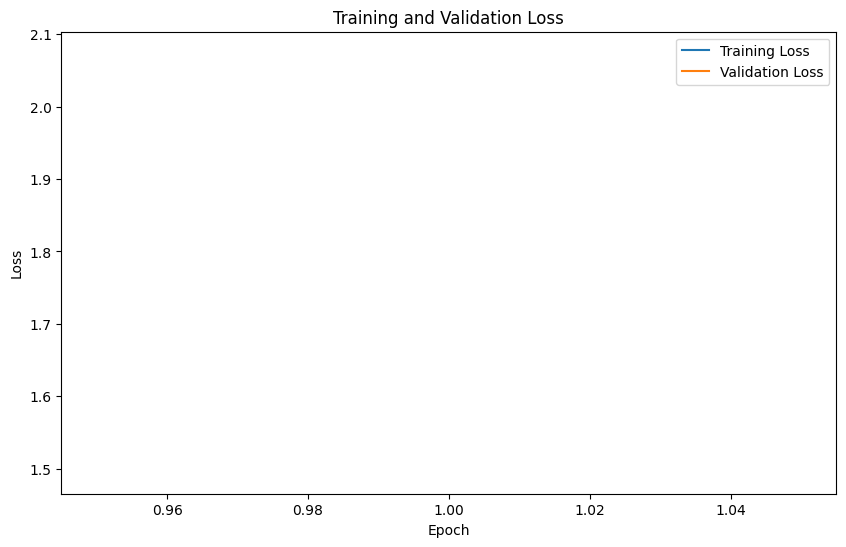

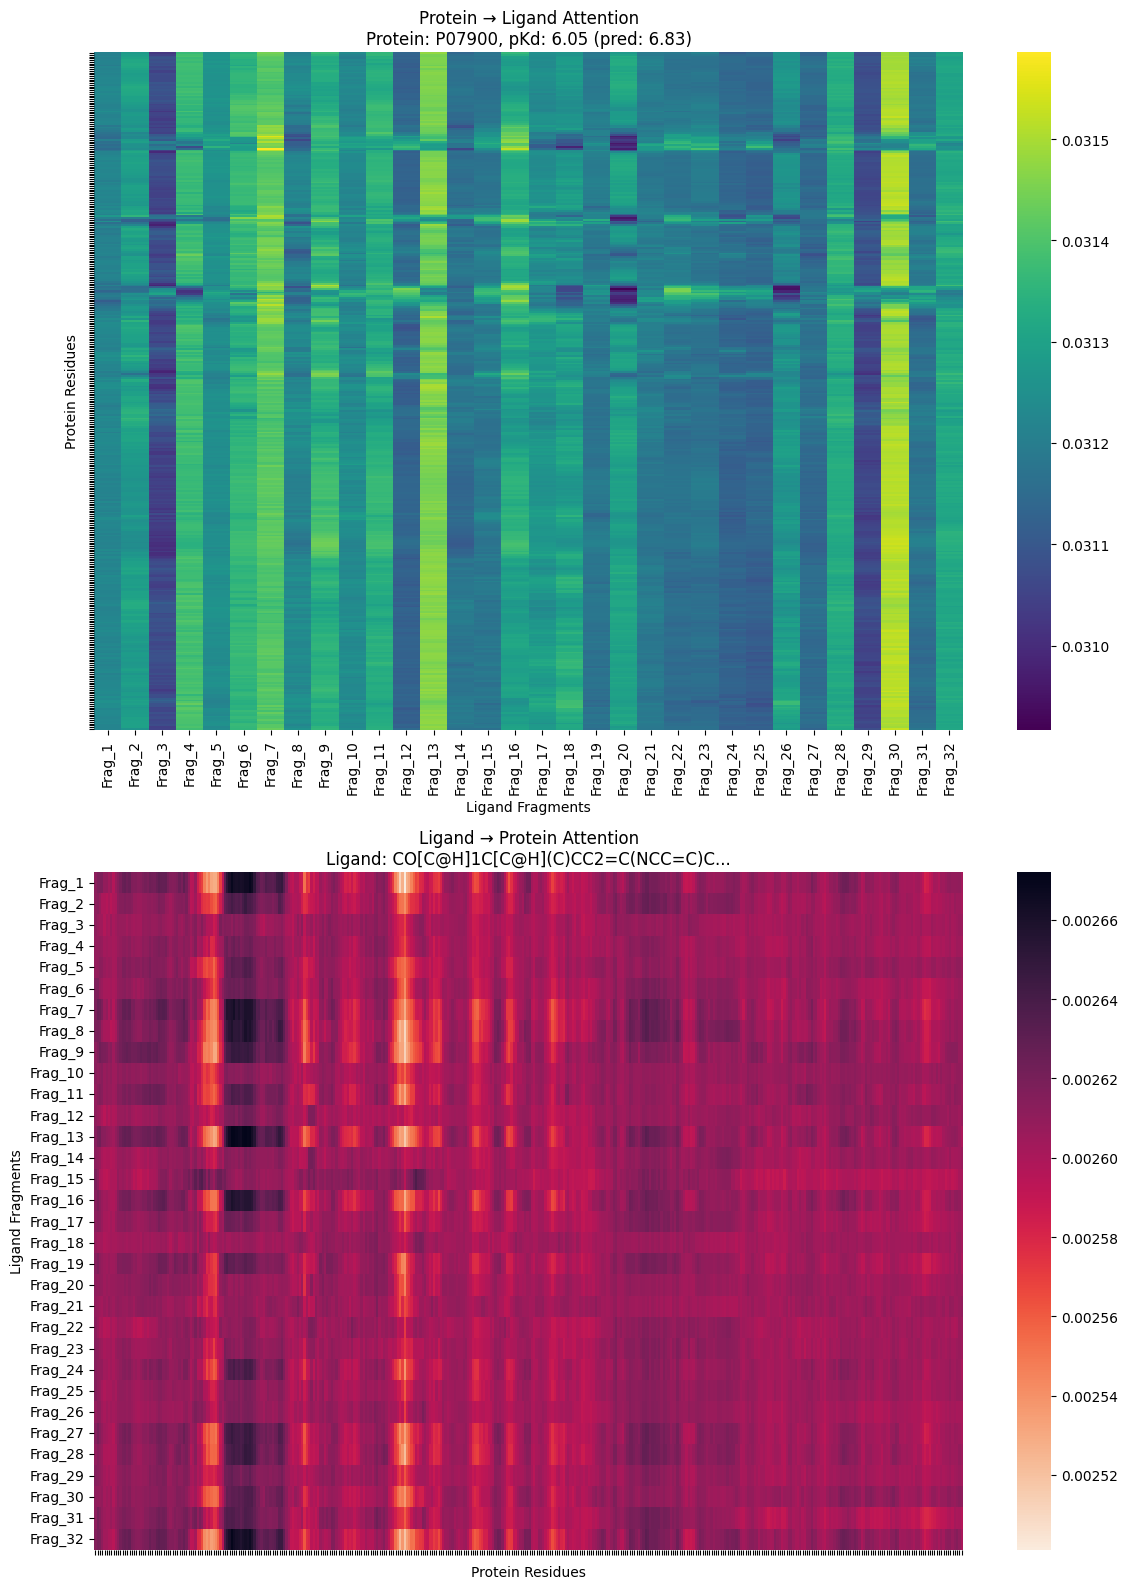

<Figure size 1600x800 with 0 Axes>

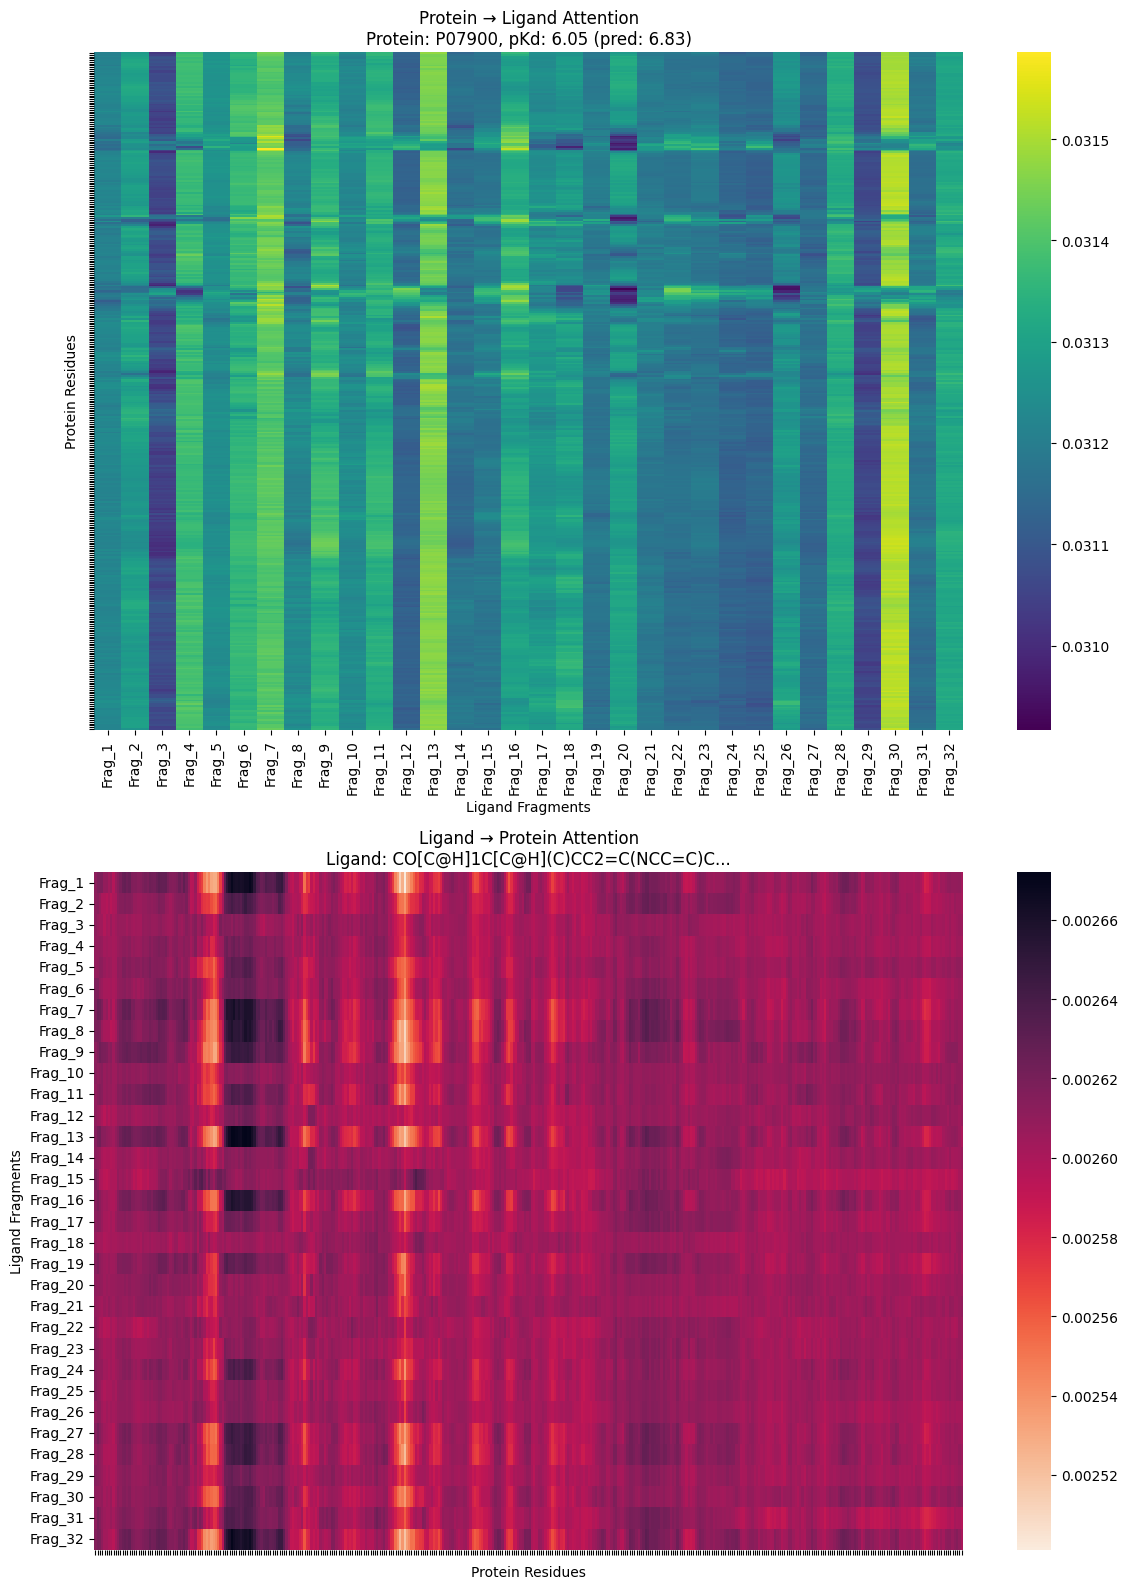

<Figure size 1600x800 with 0 Axes>

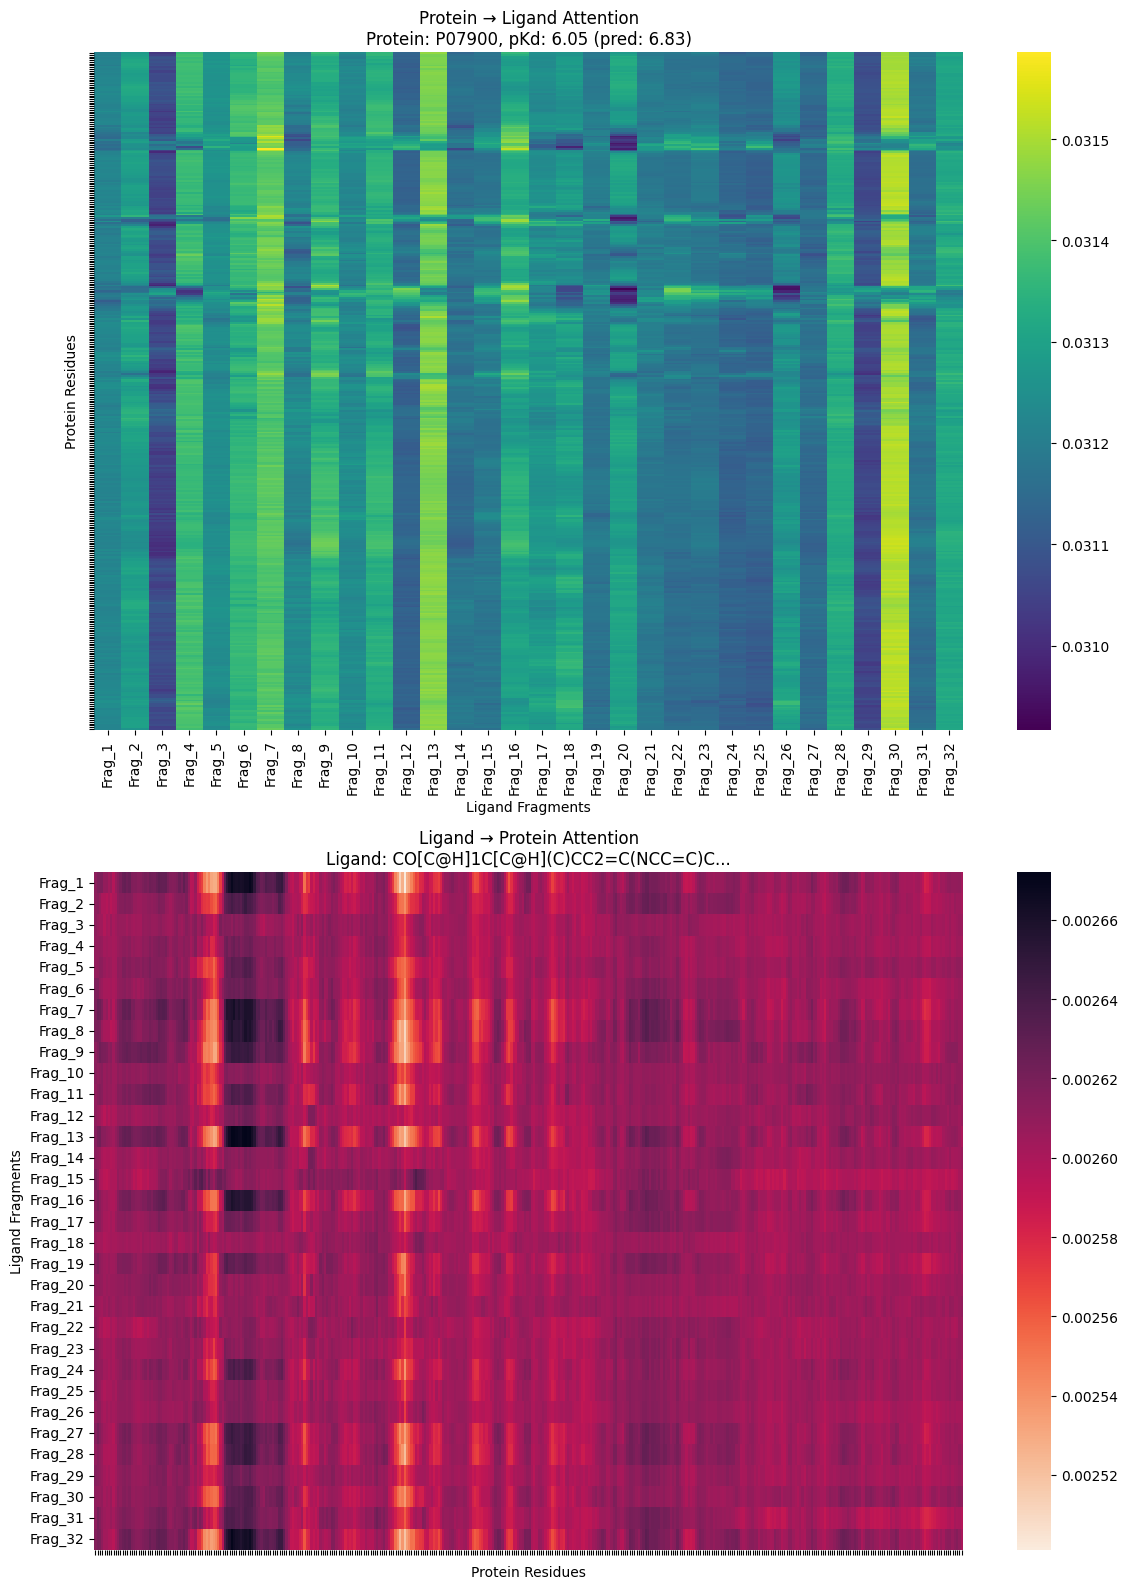

<Figure size 1600x800 with 0 Axes>

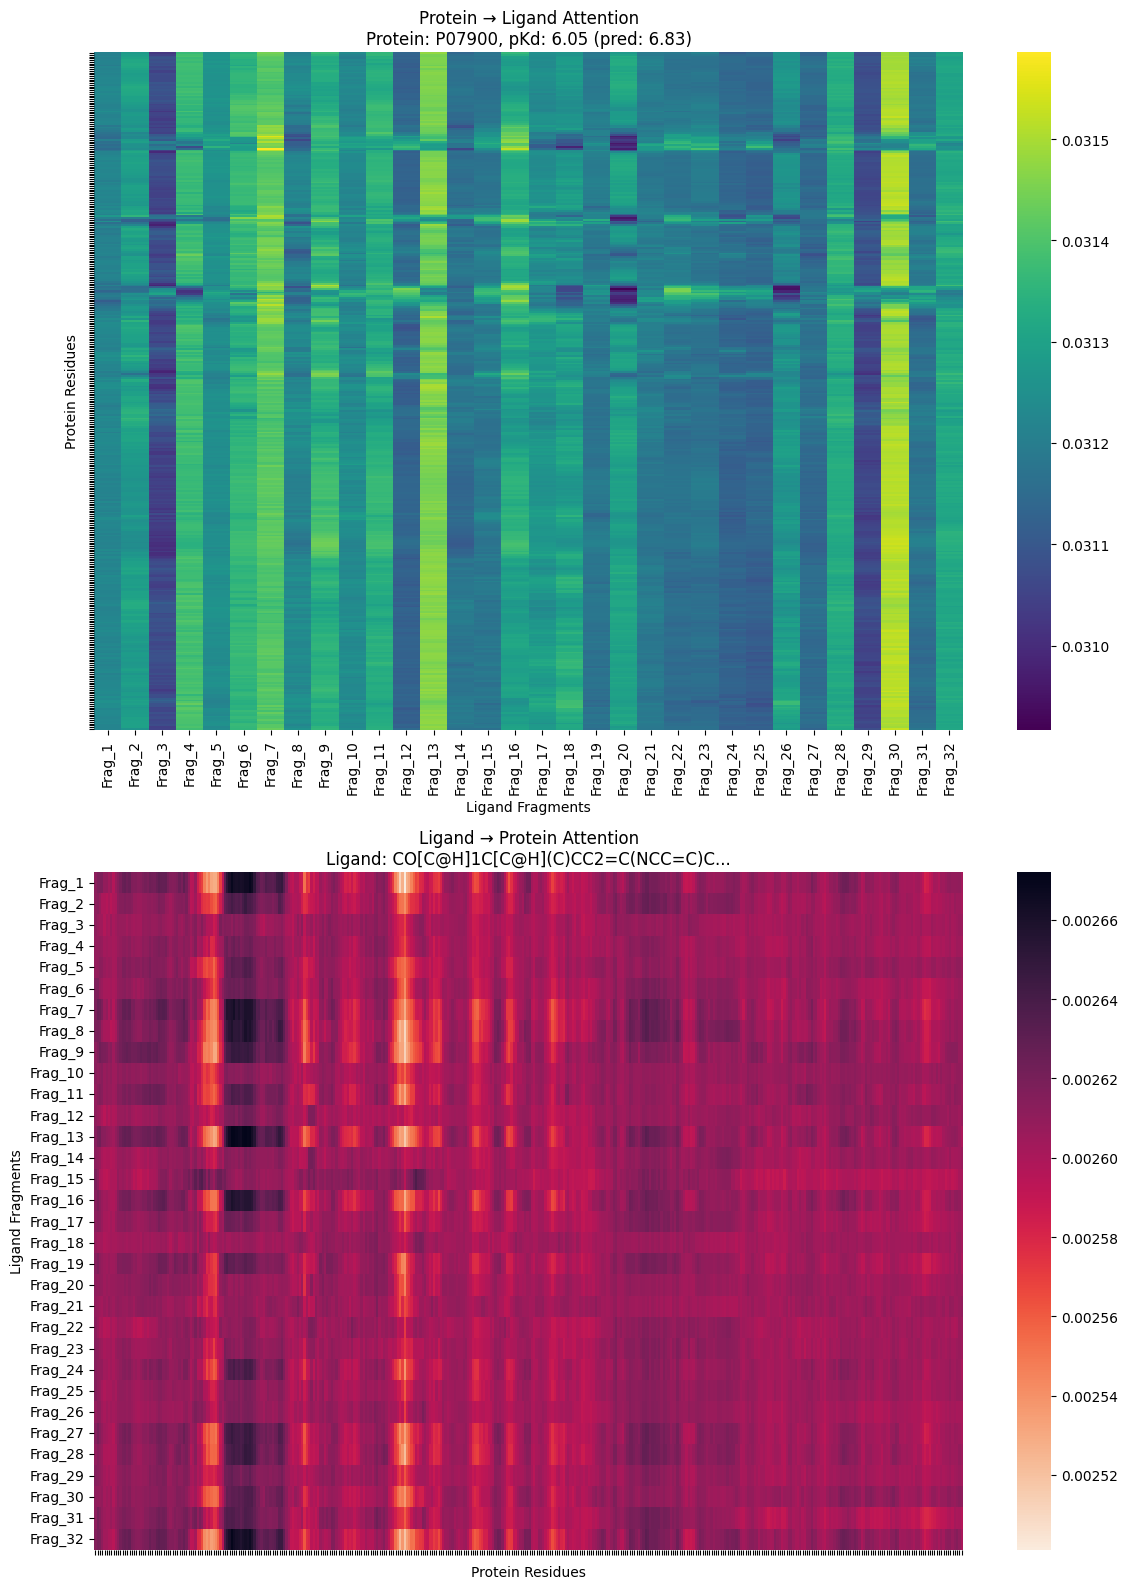

<Figure size 1600x800 with 0 Axes>

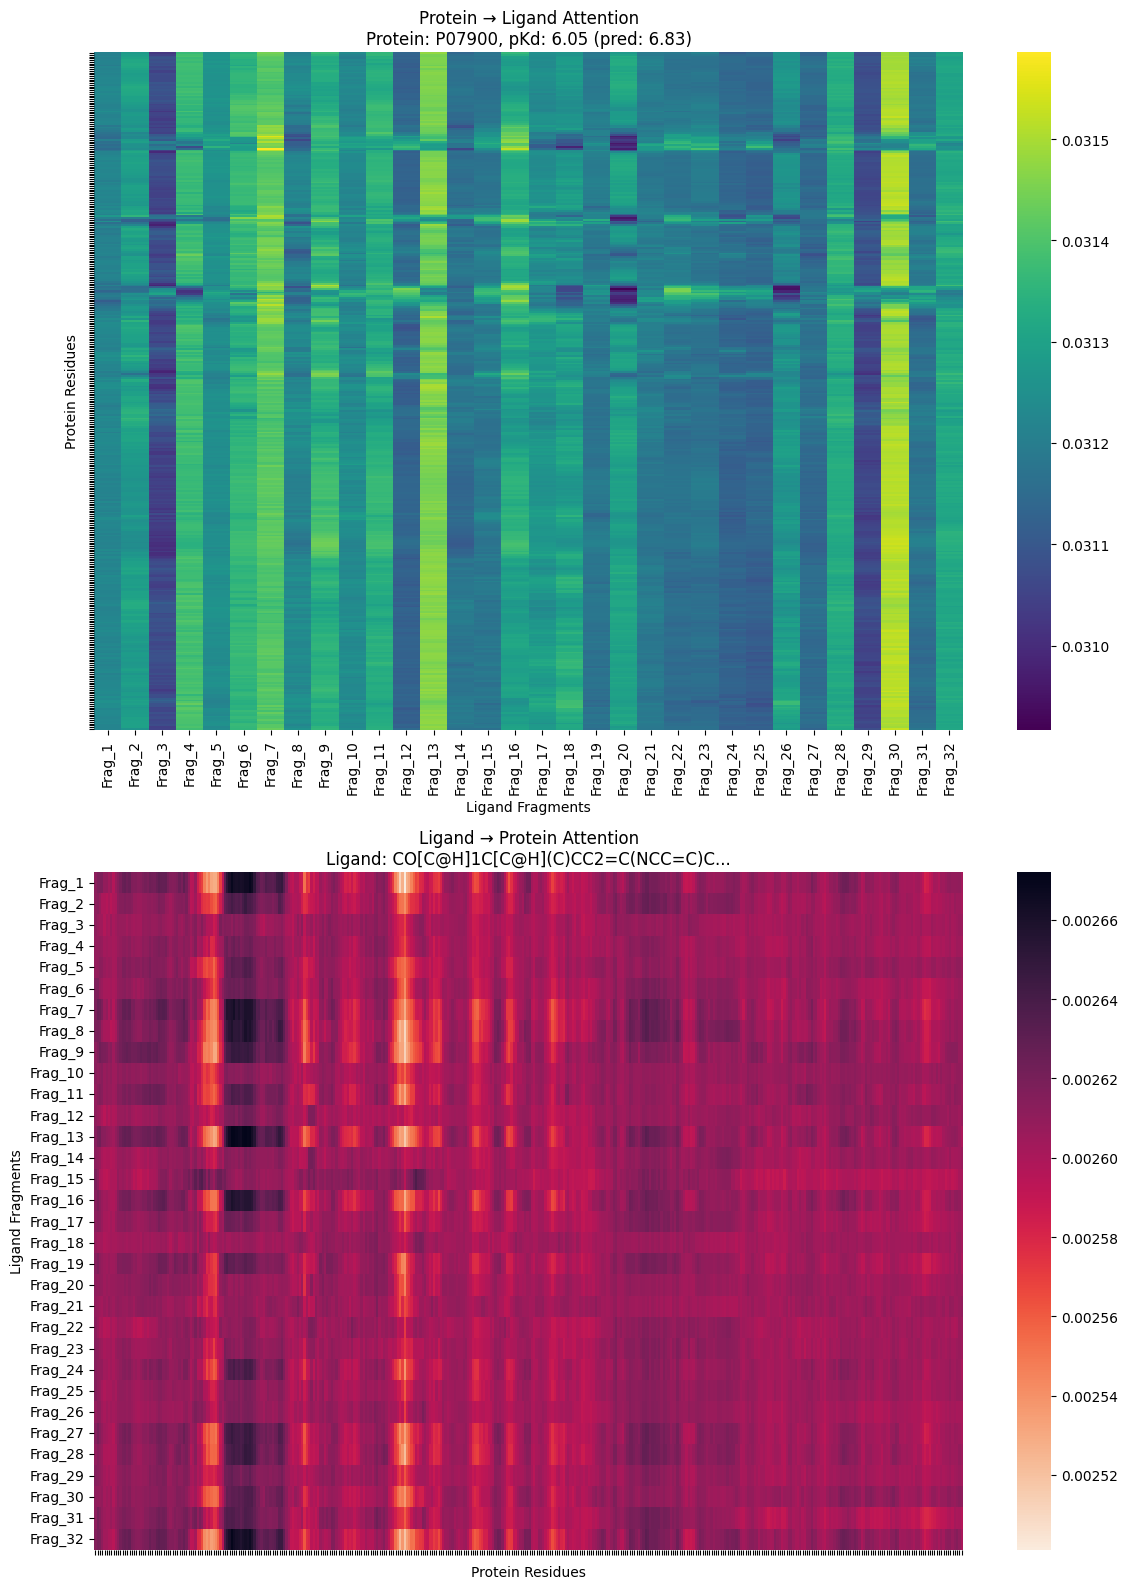

<Figure size 1600x800 with 0 Axes>

In [53]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(range(1, TOTAL_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, TOTAL_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('training_history.png')

# Visualize attention on some examples
print("🔍 Generating attention visualizations...")
for idx in range(min(5, len(val_ds))):
    visualize_attention(model, val_loader, tokenizer, sample_idx=0, save_path="attention_viz.png", 
                   attention_threshold=0.2)

In [56]:
def default_smiles_to_fragments(smiles_string, num_fragments=32):
    """
    Simple default function to identify fragments in a SMILES string
    Returns list of fragment names and their SMILES representations
    
    Fixed to be compatible with different RDKit versions
    """
    try:
        # Parse the SMILES string
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return [f"Frag_{i+1}" for i in range(num_fragments)], None
            
        # Generate 2D coordinates
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        mol = Chem.RemoveHs(mol)
        
        # Identify basic fragments
        fragments = []
        smiles_fragments = []
        
        # 1. Try to identify ring systems - using GetSymmSSSR() which is more stable across versions
        # For newer RDKit versions, use either GetSymmSSSR() or use direct ring info
        ring_atoms = set()
        try:
            # Attempt newer RDKit method
            ring_info = mol.GetRingInfo()
            rings = ring_info.AtomRings()
            for ring in rings:
                ring_atoms.update(ring)
                ring_mol = Chem.PathToSubmol(mol, list(ring))
                fragments.append(f"Ring{len(fragments)+1}")
                smiles_fragments.append(Chem.MolToSmiles(ring_mol))
        except AttributeError:
            # Fall back to older method
            try:
                rings = Chem.GetSymmSSSR(mol)
                for ring in rings:
                    ring_atoms.update(ring)
                    ring_mol = Chem.PathToSubmol(mol, [a for a in ring])
                    fragments.append(f"Ring{len(fragments)+1}")
                    smiles_fragments.append(Chem.MolToSmiles(ring_mol))
            except:
                # If all ring detection methods fail, log and continue
                print("Warning: Ring detection failed, continuing with functional groups only")
        
        # 2. Try to identify functional groups
        for atom in mol.GetAtoms():
            # Skip atoms already in ring systems
            if atom.GetIdx() in ring_atoms:
                continue
            
            # Look for common heteroatoms and their neighbors
            if atom.GetSymbol() in ['O', 'N', 'S', 'P', 'F', 'Cl', 'Br', 'I']:
                group_name = f"{atom.GetSymbol()}-group"
                # Get the neighbor atoms to include in the fragment
                neighbors = [n.GetIdx() for n in atom.GetNeighbors()]
                if neighbors:
                    substructure = Chem.PathToSubmol(mol, [atom.GetIdx()] + neighbors)
                    fragments.append(group_name)
                    smiles_fragments.append(Chem.MolToSmiles(substructure))
        
        # 3. Add carbon chains
        remaining_atoms = set(range(mol.GetNumAtoms())) - ring_atoms
        visited = set()
        for atom_idx in remaining_atoms:
            if atom_idx in visited:
                continue
            
            # Start a new carbon chain
            atom = mol.GetAtomWithIdx(atom_idx)
            if atom.GetSymbol() == 'C':
                # Find connected carbon atoms
                chain = [atom_idx]
                visited.add(atom_idx)
                stack = [atom_idx]
                
                while stack:
                    current = stack.pop()
                    for neighbor in mol.GetAtomWithIdx(current).GetNeighbors():
                        n_idx = neighbor.GetIdx()
                        if n_idx not in visited and n_idx in remaining_atoms and neighbor.GetSymbol() == 'C':
                            chain.append(n_idx)
                            visited.add(n_idx)
                            stack.append(n_idx)
                
                if chain:
                    substructure = Chem.PathToSubmol(mol, chain)
                    fragments.append(f"C-chain{len(fragments)+1}")
                    smiles_fragments.append(Chem.MolToSmiles(substructure))
        
        # 4. Add any remaining atoms
        remaining = set(range(mol.GetNumAtoms())) - visited - ring_atoms
        for atom_idx in remaining:
            atom = mol.GetAtomWithIdx(atom_idx)
            if atom.GetSymbol() not in ['H']:  # Skip hydrogens
                fragments.append(f"{atom.GetSymbol()}{len(fragments)+1}")
                atom_mol = Chem.MolFromSmiles(atom.GetSymbol())
                smiles_fragments.append(Chem.MolToSmiles(atom_mol))
        
        # If we have more identified fragments than model fragments, merge some
        if len(fragments) > num_fragments:
            # Simplify by taking the first num_fragments
            fragments = fragments[:num_fragments]
            smiles_fragments = smiles_fragments[:num_fragments]
        
        # If we have fewer fragments than the model expects, pad with empty labels
        while len(fragments) < num_fragments:
            fragments.append(f"Frag_{len(fragments)+1}")
            smiles_fragments.append("")
        
        return fragments, smiles_fragments
            
    except Exception as e:
        print(f"Error processing SMILES: {e}")
        return [f"Frag_{i+1}" for i in range(num_fragments)], None

In [ ]:
# Updated function to fetch protein name from UniProt
def fetch_protein_info(uniprot_id):
    """
    Fetch protein name and sequence from UniProt API
    
    Args:
        uniprot_id: UniProt accession ID (e.g. 'P12345')
        
    Returns:
        Dictionary with protein name and sequence
    """
    try:
        # First, try to get the protein name
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}"
        response = requests.get(url, headers={"Accept": "application/json"})
        
        if response.status_code == 200:
            data = response.json()
            protein_name = data.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', '')
            if not protein_name:
                # Try alternative names if recommended name is not available
                protein_name = data.get('proteinDescription', {}).get('alternativeNames', [{}])[0].get('fullName', {}).get('value', '')
            
            # If still no name found, use other fields
            if not protein_name:
                protein_name = data.get('proteinDescription', {}).get('submissionNames', [{}])[0].get('fullName', {}).get('value', '')
                
            # Fallback if name is still not found
            if not protein_name:
                protein_name = f"Protein {uniprot_id}"
                
            # Now fetch the sequence in FASTA format
            sequence_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
            seq_response = requests.get(sequence_url)
            
            sequence = ""
            if seq_response.status_code == 200:
                # Parse FASTA format (skip header line)
                lines = seq_response.text.strip().split('\n')
                sequence = ''.join(lines[1:])
            
            return {
                "name": protein_name,
                "sequence": sequence,
                "uniprot_id": uniprot_id
            }
        else:
            print(f"Error fetching UniProt info: HTTP {response.status_code}")
            return {
                "name": f"Protein {uniprot_id}",
                "sequence": "",
                "uniprot_id": uniprot_id
            }
    except Exception as e:
        print(f"Error fetching UniProt info: {e}")
        return {
            "name": f"Protein {uniprot_id}",
            "sequence": "",
            "uniprot_id": uniprot_id
        }

In [82]:
# Function to render molecule fragment as image
def smiles_to_image(smiles, width=200, height=150):
    """Convert SMILES to PNG image"""
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit.Chem.Draw import rdMolDraw2D
    from io import BytesIO
    
    if not smiles:
        return None
    
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
            
        # Generate 2D coordinates
        AllChem.Compute2DCoords(mol)
        
        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(width, height)
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        
        # Convert to png image
        png_data = drawer.GetDrawingText()
        return BytesIO(png_data)
    except Exception as e:
        print(f"Error rendering molecule: {e}")
        return None
# Example of how to create the top 6 chemical fragment visualization
def visualize_top_interactions(residue_labels, fragment_names, fragment_smiles, residue_attn, save_path=None):
    """
    Visualize the top 6 protein-ligand interactions with chemical structures
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get top residue-fragment pairs based on attention
    all_pairs = []
    
    for y in range(residue_attn.shape[0]):
        for x in range(residue_attn.shape[1]):
            all_pairs.append((y, x, residue_attn[y, x]))
    
    # Sort by attention value (descending) and take top 6
    all_pairs.sort(key=lambda pair: pair[2], reverse=True)
    top_pairs = all_pairs[:6]
    
    # Create subplot grid for top 6 pairs
    if top_pairs:
        # Calculate grid dimensions
        n_pairs = len(top_pairs)
        n_cols = min(3, n_pairs)
        n_rows = (n_pairs + n_cols - 1) // n_cols
        
        plt.figure(figsize=(18, 12))
        plt.suptitle(f"Top Protein Residue - Ligand Fragment Interactions", fontsize=16)
        
        for i, (res_idx, frag_idx, attn_val) in enumerate(top_pairs):
            plt.subplot(n_rows, n_cols, i+1)
            
            # Get the fragment SMILES
            frag_smiles_str = fragment_smiles[frag_idx] if frag_idx < len(fragment_smiles) else ""
            
            if frag_smiles_str:
                # Render the chemical fragment
                img_data = smiles_to_image(frag_smiles_str)
                if img_data:
                    img = plt.imread(img_data)
                    plt.imshow(img)
                    plt.axis('off')
            
            plt.title(f"{residue_labels[res_idx]} ↔ {fragment_names[frag_idx]}\nAttention: {attn_val:.4f}")
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Chemical visualization saved to {save_path}")
        else:
            plt.show()

In [ ]:
def visualize_molecule_with_labels(
    ligand_smiles, 
    fragment_data, 
    fragment_attention_weights,
    save_path=None
):
    """
    Legacy wrapper for backwards compatibility
    """
    from rdkit import Chem
    import numpy as np
    
    # Convert fragment_attention_weights to numpy array for consistency
    frag_names = list(fragment_attention_weights.keys())
    frag_weights = list(fragment_attention_weights.values())
    
    # Create dummy residue_attn matrix
    residue_attn = np.array(frag_weights).reshape(1, -1)
    
    return visualize_molecule_with_top_attention_labels(
        ligand_smiles, 
        fragment_data, 
        residue_attn,
        ['Dummy'],  # dummy residue label
        frag_names,
        save_path
    )

def visualize_molecule_with_top_attention_labels(
    ligand_smiles, 
    fragment_data,  # List of (name, smiles) tuples
    residue_attn,   # Protein -> Ligand attention matrix
    residue_labels, # Corresponding residue labels
    fragment_names, # Fragment names corresponding to attention matrix columns
    save_path=None,
    top_n=6  # Limit to top 6 substructures
):
    """
    Visualize molecule with labels based on top protein -> ligand attention weights
    
    Args:
        ligand_smiles (str): Full ligand SMILES string
        fragment_data (list): List of (fragment_name, fragment_smiles) tuples
        residue_attn (np.ndarray): Protein -> Ligand attention matrix
        residue_labels (list): Labels for protein residues
        fragment_names (list): Names of ligand fragments
        save_path (str, optional): Path to save the molecule visualization
        top_n (int, optional): Number of top fragments to label
    
    Returns:
        RDKit molecule drawing
    """
    from rdkit import Chem
    from rdkit.Chem import Draw
    import numpy as np
    
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(ligand_smiles)
    
    # Precompute fragment atom mappings
    fragment_atom_maps = {}
    for frag_name, frag_smiles in fragment_data:
        if not frag_smiles:
            continue
        
        frag_mol = Chem.MolFromSmiles(frag_smiles)
        
        # Find substructure matches in the full molecule
        matches = mol.GetSubstructMatches(frag_mol)
        
        if matches:
            # Take the first match (most relevant)
            atom_indices = matches[0]
            fragment_atom_maps[frag_name] = atom_indices
    
    # Calculate fragment attention weights
    fragment_max_weights = np.max(residue_attn, axis=0)
    
    # Sort fragments by attention weights
    sorted_fragment_indices = np.argsort(fragment_max_weights)[::-1]
    
    # Prepare atom annotations
    atom_annotations = {}
    for rank, frag_idx in enumerate(sorted_fragment_indices[:top_n]):
        frag_name = fragment_names[frag_idx]
        weight = fragment_max_weights[frag_idx]
        
        if frag_name in fragment_atom_maps:
            atom_indices = fragment_atom_maps[frag_name]
            
            # Create annotation with rank and weight
            annotation = f"{rank+1}: {weight:.3f}"
            
            # Annotate each atom in the fragment
            for idx in atom_indices:
                atom_annotations[idx] = annotation
    
    # Prepare drawing
    drawer = Draw.MolDraw2DCairo(800, 800)
    drawer.drawOptions().addAtomIndices = False
    drawer.drawOptions().addStereoAnnotation = True
    drawer.drawOptions().atomLabelFontSize = 24  # Smaller font size
    
    # Add custom annotations
    for atom_idx, annotation in atom_annotations.items():
        drawer.drawOptions().atomLabelDeuteriumTritium[atom_idx] = annotation
    
    # Highlight atoms
    drawer.DrawMolecule(
        mol, 
        highlightAtoms=list(atom_annotations.keys()),
        highlightBonds=[],
        highlightAtomColors={idx: (0.8, 0.8, 1.0) for idx in atom_annotations.keys()}
    )
    drawer.FinishDrawing()
    
    # Save or return image
    if save_path:
        with open(save_path, 'wb') as f:
            f.write(drawer.GetDrawingText())
        print(f"Molecule visualization saved to {save_path}")
    
    return drawer.GetDrawingText()

def visualize_molecule_with_top_attention_labels(
    ligand_smiles, 
    fragment_data,  # List of (name, smiles) tuples
    residue_attn,   # Protein -> Ligand attention matrix
    residue_labels, # Corresponding residue labels
    fragment_names, # Fragment names corresponding to attention matrix columns
    save_path=None,
    top_n=6  # Limit to top 6 substructures
):
    """
    Visualize molecule with labels based on top protein -> ligand attention weights
    
    Args:
        ligand_smiles (str): Full ligand SMILES string
        fragment_data (list): List of (fragment_name, fragment_smiles) tuples
        residue_attn (np.ndarray): Protein -> Ligand attention matrix
        residue_labels (list): Labels for protein residues
        fragment_names (list): Names of ligand fragments
        save_path (str, optional): Path to save the molecule visualization
        top_n (int, optional): Number of top fragments to label
    
    Returns:
        RDKit molecule drawing
    """
    from rdkit import Chem
    from rdkit.Chem import Draw
    import numpy as np
    
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(ligand_smiles)
    
    # Precompute fragment atom mappings
    fragment_atom_maps = {}
    for frag_name, frag_smiles in fragment_data:
        if not frag_smiles:
            continue
        
        frag_mol = Chem.MolFromSmiles(frag_smiles)
        
        # Find substructure matches in the full molecule
        matches = mol.GetSubstructMatches(frag_mol)
        
        if matches:
            # Take the first match (most relevant)
            atom_indices = matches[0]
            fragment_atom_maps[frag_name] = atom_indices
    
    # Calculate fragment attention weights
    fragment_max_weights = np.max(residue_attn, axis=0)
    
    # Sort fragments by attention weights
    sorted_fragment_indices = np.argsort(fragment_max_weights)[::-1]
    
    # Prepare atom annotations
    atom_annotations = {}
    for rank, frag_idx in enumerate(sorted_fragment_indices[:top_n]):
        frag_name = fragment_names[frag_idx]
        weight = fragment_max_weights[frag_idx]
        
        if frag_name in fragment_atom_maps:
            atom_indices = fragment_atom_maps[frag_name]
            
            # Create annotation with rank and weight
            annotation = f"{rank+1}: {weight:.3f}"
            
            # Annotate each atom in the fragment
            for idx in atom_indices:
                atom_annotations[idx] = annotation
    
    # Prepare drawing
    drawer = Draw.MolDraw2DCairo(800, 800)
    drawer.drawOptions().addAtomIndices = False
    drawer.drawOptions().addStereoAnnotation = True
    drawer.drawOptions().atomLabelFontSize = 24  # Smaller font size
    
    # Add custom annotations
    for atom_idx, annotation in atom_annotations.items():
        drawer.drawOptions().atomLabelDeuteriumTritium[atom_idx] = annotation
    
    # Highlight atoms
    drawer.DrawMolecule(
        mol, 
        highlightAtoms=list(atom_annotations.keys()),
        highlightBonds=[],
        highlightAtomColors={idx: (0.8, 0.8, 1.0) for idx in atom_annotations.keys()}
    )
    drawer.FinishDrawing()
    
    # Save or return image
    if save_path:
        with open(save_path, 'wb') as f:
            f.write(drawer.GetDrawingText())
        print(f"Molecule visualization saved to {save_path}")
    
    return drawer.GetDrawingText()            # Generate molecule with top attention labels
            fragment_data = [(name, smiles) for name, smiles in zip(fragment_names, fragment_smiles) if smiles]
            visualize_molecule_with_top_attention_labels(
                ligand_smiles, 
                fragment_data, 
                residue_attn,
                residue_labels,
                fragment_names,
                save_path=molecule_path
            )

SyntaxError: invalid syntax (3133090819.py, line 123)

In [ ]:
def generate_attention_heatmaps(residue_attn, frag_to_residue_attn, protein_name, uniprot_id, 
                               ligand_smiles, fragment_names, residue_labels, 
                               pkd_value, pred_pkd, save_path=None):
    """
    Generate heatmap visualizations for protein-ligand attention.
    
    Args:
        residue_attn: Protein -> Ligand attention matrix (residues x fragments)
        frag_to_residue_attn: Ligand -> Protein attention matrix (fragments x residues)
        protein_name: Full name of the protein from UniProt
        uniprot_id: UniProt ID of the protein
        ligand_smiles: SMILES string of the ligand
        fragment_names: List of fragment names
        residue_labels: List of residue labels
        pkd_value: True pKd value
        pred_pkd: Predicted pKd value
        save_path: Path to save the heatmap visualization
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Create figure for heatmaps
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [1, 1]})
    
    # Plot 1: Protein -> Ligand attention - Hide y-axis tick labels
    sns.heatmap(residue_attn, ax=ax1, cmap="viridis", 
                xticklabels=fragment_names,
                yticklabels=[""] * len(residue_labels))  # Empty strings for y-tick labels
    
    # Updated title format
    ax1.set_title(f"Protein → Ligand Attention Map\n"
                 f"Protein: {protein_name} ({uniprot_id})\n"
                 f"Ligand: {ligand_smiles}\n"
                 f"validation pKd: {pkd_value:.2f} (pred: {pred_pkd:.2f})",
                 fontsize=12)
    
    ax1.set_ylabel("Protein Residues")
    ax1.set_xlabel("Ligand Fragments")
    
    # Plot 2: Ligand -> Protein attention with hidden x-axis tick labels
    sns.heatmap(frag_to_residue_attn, ax=ax2, cmap="rocket_r",
                yticklabels=fragment_names,
                xticklabels=[""] * len(residue_labels))  # Empty strings for x-tick labels
    
    ax2.set_title(f"Ligand → Protein Attention Map")
    ax2.set_ylabel("Ligand Fragments")
    ax2.set_xlabel("Protein Residues")
    
    # No annotation on the heatmap as per requirements
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap visualization saved to {save_path}")
    else:
        plt.show()
        
    return fig

In [79]:
def visualize_binding_predictions(model, dataloader, tokenizer, sample_idx=0, output_dir=None):
    """
    Generate all visualizations for a protein-ligand binding prediction
    
    Args:
        model: Trained binding affinity model
        dataloader: DataLoader containing samples
        tokenizer: ESM tokenizer
        sample_idx: Index of the sample to visualize
        output_dir: Directory to save visualizations
    """
    # Get a batch
    for i, (tokenized_seq, ligand_fp, pkd, metadata) in enumerate(dataloader):
        if i == sample_idx // dataloader.batch_size:
            idx_in_batch = sample_idx % dataloader.batch_size
            if idx_in_batch >= len(tokenized_seq['input_ids']):
                print(f"Sample index {sample_idx} exceeds batch size {len(tokenized_seq['input_ids'])}")
                return
            
            # Get single sample
            tokens = {k: v[idx_in_batch:idx_in_batch+1] for k, v in tokenized_seq.items()}
            fp = ligand_fp[idx_in_batch:idx_in_batch+1]
            pkd_value = pkd[idx_in_batch].item()
            meta = {k: v[idx_in_batch] for k, v in metadata.items()}
            
            # Get SMILES string and protein info
            ligand_smiles = meta['LigandSMILES']
            uniprot_id = meta['ProteinID']
            
            # Get protein name from UniProt
            protein_info = fetch_protein_info(uniprot_id)
            protein_name = protein_info["name"]
            
            # Generate fragment names and SMILES for the ligand
            fragment_names, fragment_smiles = default_smiles_to_fragments(ligand_smiles, model.T_ligand)
            
            # Run prediction with attention
            with torch.no_grad():
                outputs = model(tokens, fp, return_attention=True)
                pred_pkd, prot2lig_attn, lig2prot_attn, prot_emb, lig_emb = outputs
            
            # Process attention weights
            token_ids = tokens['input_ids'][0].cpu().numpy()
            protein_tokens = tokenizer.convert_ids_to_tokens(token_ids)
            
            prot2lig_attn = prot2lig_attn[0].mean(dim=0).cpu().numpy() 
            lig2prot_attn = lig2prot_attn[0].mean(dim=0).cpu().numpy()
            
            # Process residue information
            attention_mask = tokens['attention_mask'][0].cpu().numpy()
            valid_tokens = attention_mask.astype(bool)
            valid_protein_tokens = [t for t, m in zip(protein_tokens, valid_tokens) if m]
            valid_prot2lig_attn = prot2lig_attn[valid_tokens, :]
            
            residue_positions = []
            residue_labels = []
            for i, token in enumerate(valid_protein_tokens):
                if token.startswith("EMBL_") or token in ("<cls>", "<pad>", "<eos>", "<unk>", "<mask>"):
                    continue
                residue_positions.append(i)
                residue_labels.append(token)
            
            residue_attn = valid_prot2lig_attn[residue_positions, :]
            
            # Generate visualization paths
            if output_dir:
                import os
                os.makedirs(output_dir, exist_ok=True)
                heatmap_path = os.path.join(output_dir, f"{uniprot_id}_{ligand_smiles[:10]}_heatmap.png")
                chemical_path = os.path.join(output_dir, f"{uniprot_id}_{ligand_smiles[:10]}_chemical.png")
                molecule_path = os.path.join(output_dir, f"{uniprot_id}_{ligand_smiles[:10]}_molecule.png")
            else:
                heatmap_path = chemical_path = molecule_path = None
            
            # Generate heatmap visualizations
            generate_attention_heatmaps(
                residue_attn, 
                frag_to_residue_attn=lig2prot_attn[:, residue_positions],
                protein_name=protein_name,
                uniprot_id=uniprot_id,
                ligand_smiles=ligand_smiles,
                fragment_names=fragment_names,
                residue_labels=residue_labels,
                pkd_value=pkd_value,
                pred_pkd=pred_pkd.item(),
                save_path=heatmap_path
            )
            
            # Generate fragment chemical visualizations
            visualize_top_interactions(
                residue_labels=residue_labels,
                fragment_names=fragment_names,
                fragment_smiles=fragment_smiles,
                residue_attn=residue_attn,
                save_path=chemical_path
            )
            
            # Calculate fragment attention weights
            fragment_attention_weights = {}
            for frag_idx, frag_name in enumerate(fragment_names):
                if frag_idx < lig2prot_attn.shape[0]:
                    max_attn = np.max(lig2prot_attn[frag_idx])
                    fragment_attention_weights[frag_name] = max_attn
            
            # Generate molecule with labels
            fragment_data = [(name, smiles) for name, smiles in zip(fragment_names, fragment_smiles) if smiles]
            visualize_molecule_with_labels(
                ligand_smiles, 
                fragment_data, 
                fragment_attention_weights,
                save_path=molecule_path
            )
            
            # Print prediction results
            print(f"Prediction completed for {uniprot_id} - {ligand_smiles[:30]}...")
            print(f"True pKd: {pkd_value:.2f}, Predicted pKd: {pred_pkd.item():.2f}")
            if output_dir:
                print(f"Visualizations saved to {output_dir}")
            
            return {
                'uniprot_id': uniprot_id,
                'ligand_smiles': ligand_smiles,
                'true_pkd': pkd_value,
                'predicted_pkd': pred_pkd.item(),
                'visualizations': {
                    'heatmap': heatmap_path,
                    'chemical': chemical_path,
                    'molecule': molecule_path
                }
            }
    
    print(f"Sample {sample_idx} not found in dataloader")
    return None

Error fetching UniProt info: name 'requests' is not defined
Heatmap visualization saved to ./visualization_results\P07900_CO[C@H]1C[_heatmap.png
Chemical visualization saved to ./visualization_results\P07900_CO[C@H]1C[_chemical.png
Molecule visualization saved to ./visualization_results\P07900_CO[C@H]1C[_molecule.png
Prediction completed for P07900 - CO[C@H]1C[C@H](C)CC2=C(NCC=C)C...
True pKd: 6.05, Predicted pKd: 6.83
Visualizations saved to ./visualization_results


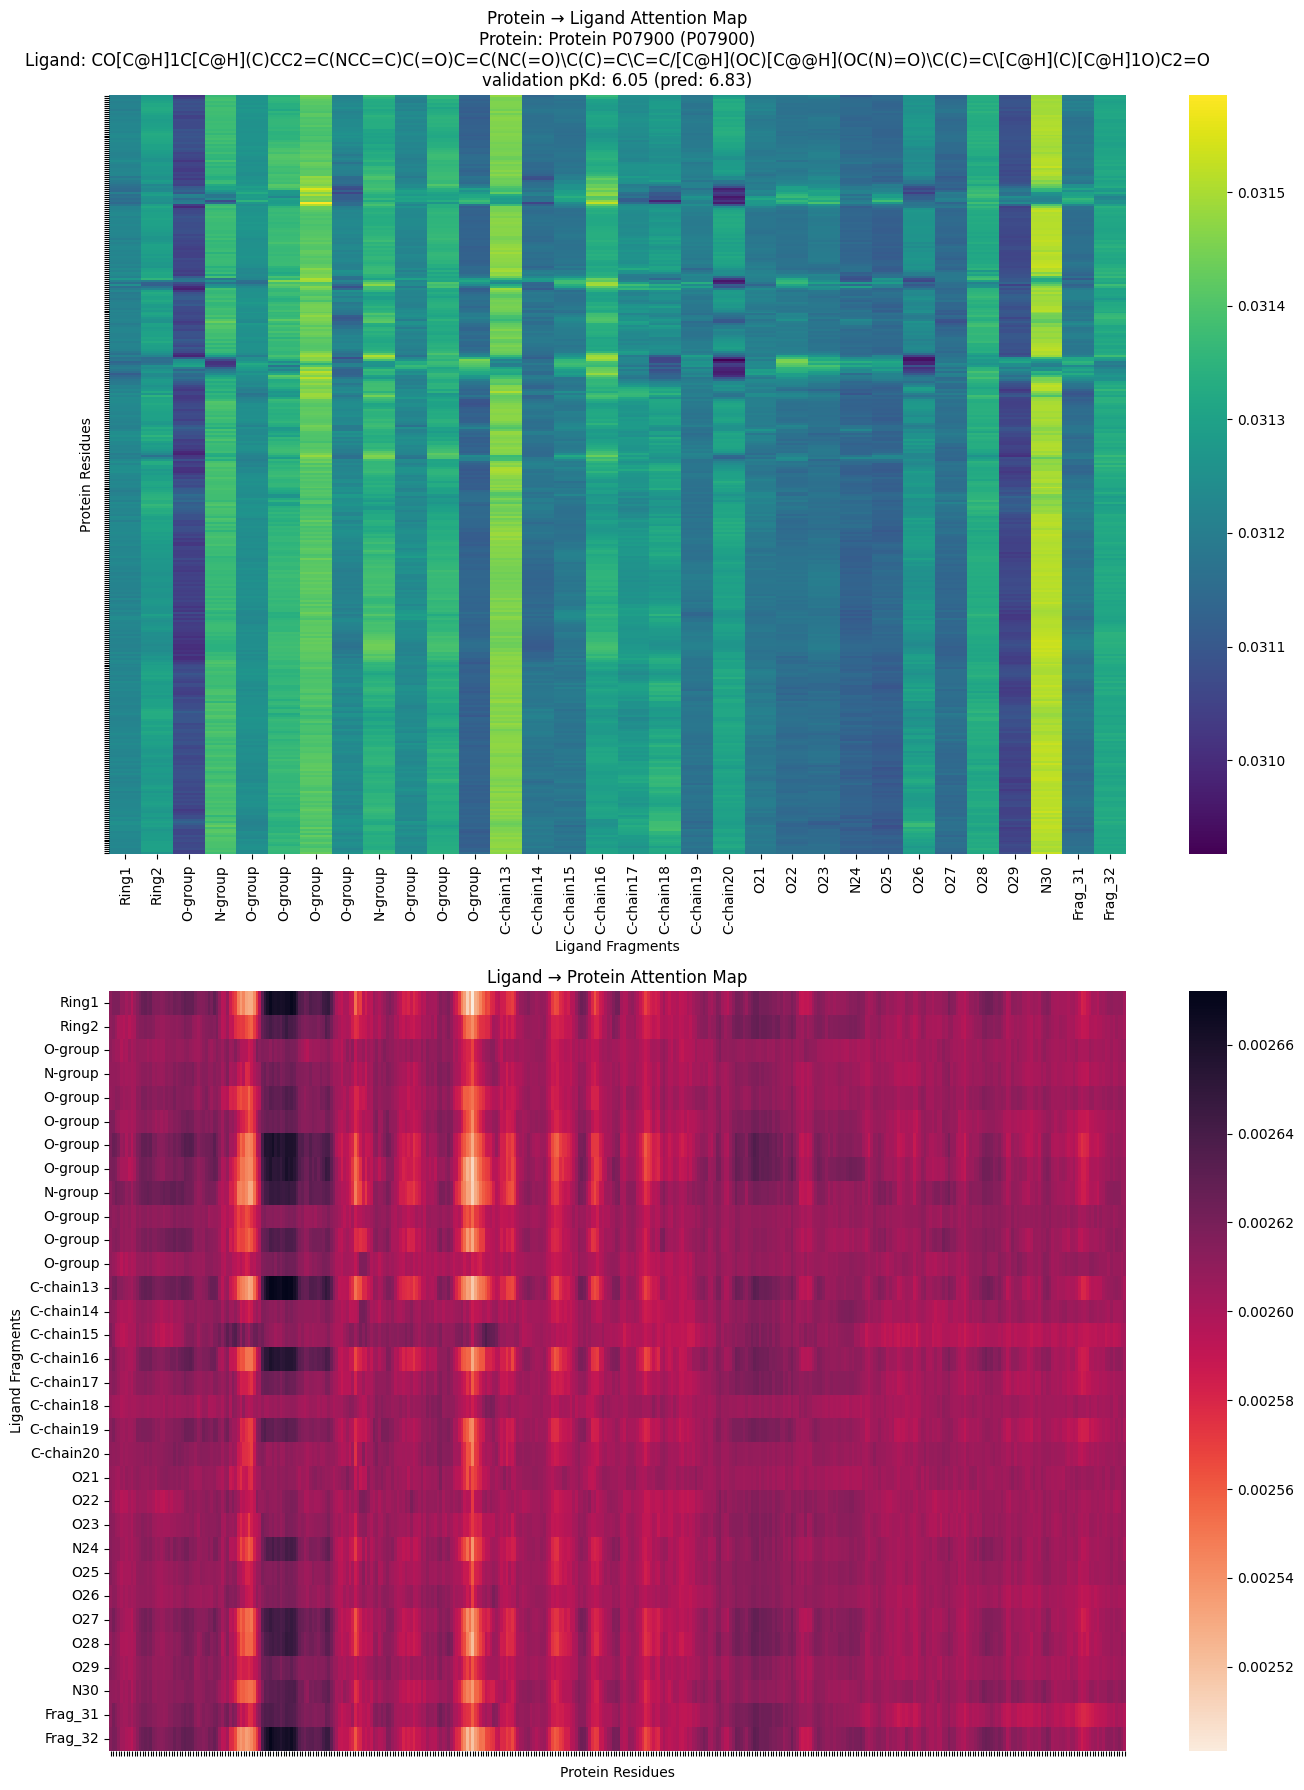

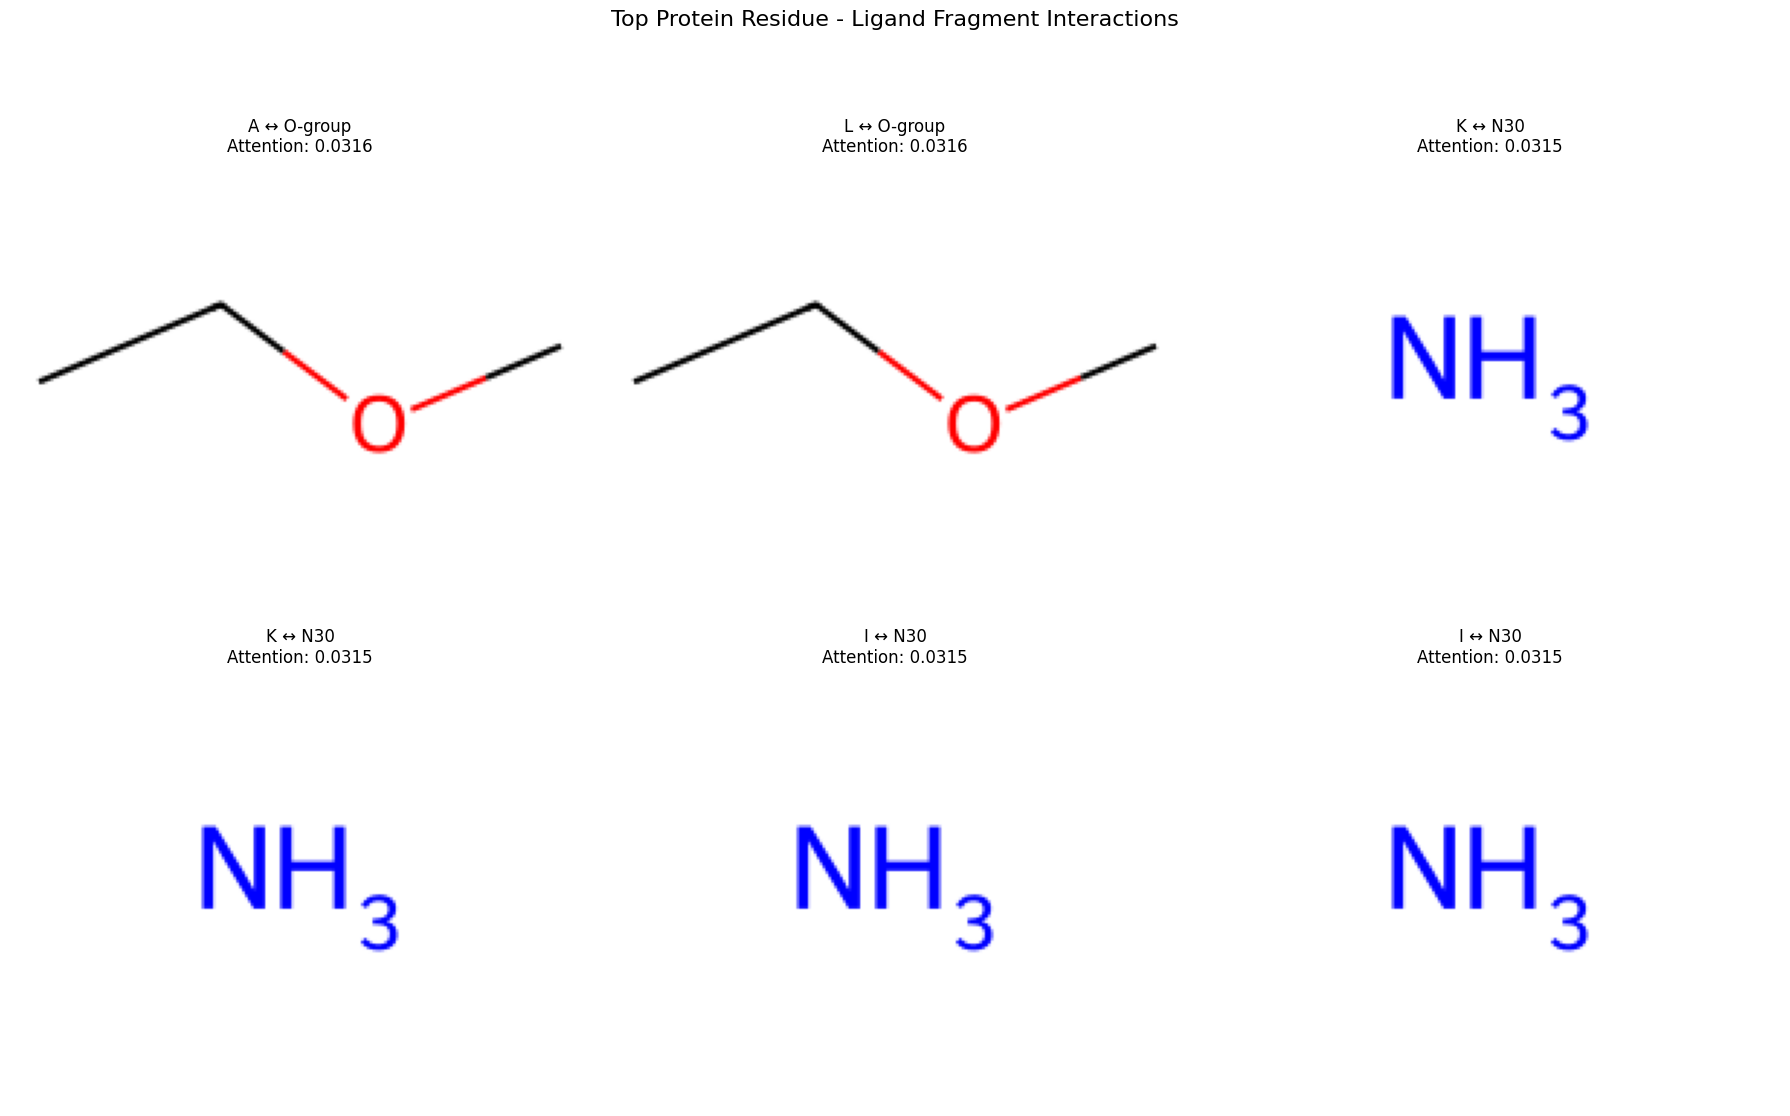

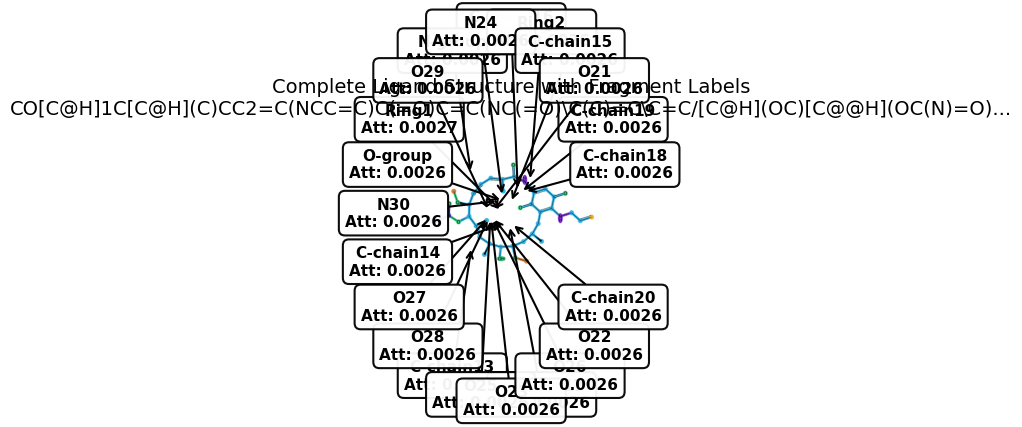

In [80]:
result = visualize_binding_predictions(
    model=model,
    dataloader=val_loader,
    tokenizer=tokenizer,
    sample_idx=0,
    output_dir="./visualization_results"
)

Needs MSE and CI (not CCC)

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, max_error, median_absolute_error
)
from scipy.stats import pearsonr, spearmanr
from lifelines.utils import concordance_index
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import math

# Set style for plots
plt.style.use('seaborn-whitegrid')
sns.set_context("talk")
colors = sns.color_palette("viridis", 8)
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", colors)

# Function to gather predictions and true values from validation set
def collect_predictions(model, dataloader, device):
    """
    Collect predictions and true values from a dataloader
    
    Args:
        model: The trained model
        dataloader: DataLoader containing validation samples
        device: Device to run model on
        
    Returns:
        DataFrame with true and predicted values, plus model embeddings
    """
    model.eval()
    results = []
    embeddings = []
    
    with torch.no_grad():
        for batch_idx, (tokenized_seq, ligand_fp, pkd_true, metadata) in enumerate(dataloader):
            # Forward pass with attention
            outputs = model(tokenized_seq, ligand_fp, return_attention=True)
            pred_pkd, prot2lig_attn, lig2prot_attn, prot_emb, lig_emb = outputs
            
            # Convert to numpy
            pred_pkd = pred_pkd.cpu().numpy()
            
            # Get protein and ligand embeddings (for dimensionality reduction plots)
            # Take the mean of embeddings across sequence length and token dimensions
            protein_embedding = prot_emb.mean(dim=1).cpu().numpy()  
            ligand_embedding = lig_emb.mean(dim=1).cpu().numpy()
            
            # Store results for each sample in batch
            for i in range(len(pred_pkd)):
                # Get metadata
                protein_id = metadata['ProteinID'][i] if 'ProteinID' in metadata else f"Protein_{batch_idx}_{i}"
                ligand_smiles = metadata['LigandSMILES'][i] if 'LigandSMILES' in metadata else f"Ligand_{batch_idx}_{i}"
                
                # Store predictions and true values
                results.append({
                    'ProteinID': protein_id,
                    'LigandSMILES': ligand_smiles, 
                    'TruePKd': pkd_true[i].item(),
                    'PredictedPKd': pred_pkd[i],
                    'Error': pkd_true[i].item() - pred_pkd[i],
                    'AbsError': abs(pkd_true[i].item() - pred_pkd[i])
                })
                
                # Store embeddings
                embeddings.append({
                    'ProteinID': protein_id,
                    'LigandSMILES': ligand_smiles,
                    'ProteinEmbedding': protein_embedding[i],
                    'LigandEmbedding': ligand_embedding[i]
                })
    
    # Convert to DataFrames
    results_df = pd.DataFrame(results)
    embeddings_df = pd.DataFrame(embeddings)
    
    return results_df, embeddings_df

# Calculate all metrics
def calculate_metrics(true_values, predicted_values):
    """Calculate comprehensive regression metrics"""
    metrics = {}
    
    # Standard regression metrics
    metrics['MSE'] = mean_squared_error(true_values, predicted_values)
    metrics['RMSE'] = math.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(true_values, predicted_values)
    metrics['MedAE'] = median_absolute_error(true_values, predicted_values)
    metrics['MAX_Error'] = max_error(true_values, predicted_values)
    metrics['R2'] = r2_score(true_values, predicted_values)
    metrics['ExplainedVariance'] = explained_variance_score(true_values, predicted_values)
    
    # Correlation metrics
    metrics['Pearson_r'], metrics['Pearson_p'] = pearsonr(true_values, predicted_values)
    metrics['Spearman_rho'], metrics['Spearman_p'] = spearmanr(true_values, predicted_values)
    
    # Concordance index (ranking metric)
    metrics['CI'] = concordance_index(true_values, predicted_values)
    
    return metrics

# Create comprehensive evaluation plots
def create_evaluation_plots(results_df, embeddings_df, metrics_dict, save_path="model_evaluation.png"):
    """Create a comprehensive set of evaluation plots"""
    
    # Extract values for plotting
    true_values = results_df['TruePKd'].values
    predicted_values = results_df['PredictedPKd'].values
    errors = results_df['Error'].values
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    gs = gridspec.GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 0.5])
    
    # 1. Scatter plot with regression line
    ax1 = fig.add_subplot(gs[0, 0])
    sns.regplot(
        x=true_values, y=predicted_values, 
        scatter_kws={'alpha':0.5, 'color':colors[5]}, 
        line_kws={'color':colors[7]}, 
        ax=ax1
    )
    
    # Add perfect prediction line
    min_val = min(min(true_values), min(predicted_values))
    max_val = max(max(true_values), max(predicted_values))
    margin = (max_val - min_val) * 0.05
    ax1.plot([min_val-margin, max_val+margin], [min_val-margin, max_val+margin], 
             '--', color='gray', alpha=0.7)
    
    ax1.set_xlabel('True pKd')
    ax1.set_ylabel('Predicted pKd')
    ax1.set_title('True vs Predicted pKd Values')
    
    # Add correlation information as text
    pearson_text = f'Pearson r = {metrics_dict["Pearson_r"]:.4f} (p = {metrics_dict["Pearson_p"]:.4e})'
    spearman_text = f'Spearman ρ = {metrics_dict["Spearman_rho"]:.4f} (p = {metrics_dict["Spearman_p"]:.4e})'
    r2_text = f'R² = {metrics_dict["R2"]:.4f}'
    
    text_str = f'{pearson_text}\n{spearman_text}\n{r2_text}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax1.text(0.05, 0.95, text_str, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # 2. Residual plot
    ax2 = fig.add_subplot(gs[0, 1])
    sns.residplot(
        x=true_values, y=predicted_values, 
        scatter_kws={'alpha':0.5, 'color':colors[4]},
        line_kws={'color':'red', 'lw':1},
        ax=ax2
    )
    ax2.set_xlabel('True pKd')
    ax2.set_ylabel('Residual (True - Predicted)')
    ax2.set_title('Residual Plot')
    ax2.axhline(y=0, color='gray', linestyle='--')
    
    # Add error statistics as text
    rmse_text = f'RMSE = {metrics_dict["RMSE"]:.4f}'
    mae_text = f'MAE = {metrics_dict["MAE"]:.4f}'
    max_error_text = f'Max Error = {metrics_dict["MAX_Error"]:.4f}'
    
    error_text = f'{rmse_text}\n{mae_text}\n{max_error_text}'
    ax2.text(0.05, 0.95, error_text, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # 3. Distribution of true vs predicted values
    ax3 = fig.add_subplot(gs[1, 0])
    sns.kdeplot(true_values, fill=True, color=colors[0], label='True pKd', ax=ax3, alpha=0.5)
    sns.kdeplot(predicted_values, fill=True, color=colors[7], label='Predicted pKd', ax=ax3, alpha=0.5)
    ax3.set_xlabel('pKd Value')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution of True and Predicted pKd Values')
    ax3.legend()
    
    # 4. Distribution of errors
    ax4 = fig.add_subplot(gs[1, 1])
    sns.histplot(errors, kde=True, color=colors[3], ax=ax4, bins=20)
    ax4.set_xlabel('Prediction Error (True - Predicted)')
    ax4.set_ylabel('Count')
    ax4.set_title('Distribution of Prediction Errors')
    
    # Add vertical line at zero
    ax4.axvline(x=0, color='red', linestyle='--')
    
    # Add error stats
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    error_stats = f'Mean = {mean_error:.4f}\nStd = {std_error:.4f}'
    ax4.text(0.75, 0.95, error_stats, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # 5. Error by true value (to check for biases)
    ax5 = fig.add_subplot(gs[2, 0])
    scatter = ax5.scatter(true_values, np.abs(errors), c=true_values, cmap=custom_cmap, alpha=0.7)
    ax5.set_xlabel('True pKd')
    ax5.set_ylabel('Absolute Error')
    ax5.set_title('Absolute Error vs True pKd')
    plt.colorbar(scatter, ax=ax5, label='True pKd')
    
    # 6. Feature embedding visualization (PCA and t-SNE)
    # First, run PCA for protein embeddings
    # Extract embeddings from dataframe
    protein_embeddings = np.stack(embeddings_df['ProteinEmbedding'].values)
    
    # Run PCA
    pca = PCA(n_components=2)
    protein_pca = pca.fit_transform(protein_embeddings)
    
    # Plot PCA results colored by prediction error
    ax6 = fig.add_subplot(gs[2, 1])
    scatter = ax6.scatter(
        protein_pca[:, 0], protein_pca[:, 1], 
        c=results_df['AbsError'], cmap='Reds', alpha=0.7, s=50
    )
    ax6.set_xlabel('PCA Component 1')
    ax6.set_ylabel('PCA Component 2')
    ax6.set_title('PCA of Protein Embeddings\n(Colored by Absolute Error)')
    plt.colorbar(scatter, ax=ax6, label='Absolute Error')
    
    # 7. Metrics table
    ax7 = fig.add_subplot(gs[3, :])
    ax7.axis('off')
    
    # Create a table of metrics
    metric_names = [
        'RMSE', 'MAE', 'MedAE', 'MAX_Error', 'R2', 'ExplainedVariance',
        'Pearson_r', 'Pearson_p', 'Spearman_rho', 'Spearman_p', 'CI'
    ]
    
    metric_values = [f"{metrics_dict[name]:.4f}" for name in metric_names]
    metric_display_names = [
        'Root Mean Squared Error', 'Mean Absolute Error', 'Median Absolute Error',
        'Maximum Error', 'R² Score', 'Explained Variance',
        'Pearson Correlation', 'Pearson p-value', 'Spearman Correlation',
        'Spearman p-value', 'Concordance Index'
    ]
    
    table_data = []
    for display_name, value in zip(metric_display_names, metric_values):
        table_data.append([display_name, value])
    
    # Create the table
    table = ax7.table(
        cellText=table_data,
        colLabels=['Metric', 'Value'],
        loc='center',
        cellLoc='center',
        colWidths=[0.6, 0.3]
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor(colors[7])
            cell.set_text_props(color='white')
        else:  # Alternate row colors
            if key[0] % 2 == 0:
                cell.set_facecolor('#f0f0f0')
    
    # Add title for the metrics table
    ax7.text(0.5, 1.05, 'Model Performance Metrics', 
             horizontalalignment='center', fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Evaluation plots saved to {save_path}")
    
    return fig

# Generate additional plots focusing on specific binding pairs
def plot_attention_heatmaps(model, dataloader, tokenizer, num_samples=5, save_dir="./attention_plots/"):
    """Generate attention heatmaps for several protein-ligand pairs"""
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    # Function to plot a single attention heatmap
    def plot_single_heatmap(tokenized_seq, ligand_fp, pkd_true, metadata, idx, save_path):
        # Forward pass with attention
        with torch.no_grad():
            outputs = model(tokenized_seq, ligand_fp, return_attention=True)
            pred_pkd, prot2lig_attn, lig2prot_attn, prot_emb, lig_emb = outputs
        
        # Decode protein sequence tokens
        token_ids = tokenized_seq['input_ids'][0].cpu().numpy()
        protein_tokens = tokenizer.convert_ids_to_tokens(token_ids)
        
        # Extract attention weights (average across heads)
        prot2lig_attn = prot2lig_attn[0].mean(dim=0).cpu().numpy()  # (L, T)
        lig2prot_attn = lig2prot_attn[0].mean(dim=0).cpu().numpy()  # (T, L)
        
        # Filter out padding tokens
        attention_mask = tokenized_seq['attention_mask'][0].cpu().numpy()
        valid_tokens = attention_mask.astype(bool)
        valid_protein_tokens = [t for t, m in zip(protein_tokens, valid_tokens) if m]
        valid_prot2lig_attn = prot2lig_attn[valid_tokens, :]
        
        # Find residue positions (ignoring special tokens)
        residue_positions = []
        residue_labels = []
        for i, token in enumerate(valid_protein_tokens):
            if token.startswith("EMBL_") or token in ("<cls>", "<pad>", "<eos>", "<unk>", "<mask>"):
                continue
            residue_positions.append(i)
            residue_labels.append(token)
        
        # Create a new attention matrix with just residues
        residue_attn = valid_prot2lig_attn[residue_positions, :]
        
        # Limit to a reasonable number of residues for visualization
        if len(residue_labels) > 30:
            step = len(residue_labels) // 30
            residue_attn = residue_attn[::step, :]
            residue_labels = residue_labels[::step]
        
        # Create ligand substructure labels
        ligand_labels = [f"Frag_{i+1}" for i in range(model.T_ligand)]
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), 
                              gridspec_kw={'height_ratios': [1, 1]})
        
        # Plot protein -> ligand attention
        sns.heatmap(residue_attn, ax=ax1, cmap="viridis", 
                    xticklabels=ligand_labels if len(ligand_labels) <= 32 else [],
                    yticklabels=residue_labels if len(residue_labels) <= 30 else [])
        ax1.set_title(f"Protein → Ligand Attention\n" 
                     f"ProteinID: {metadata['ProteinID']}, "
                     f"pKd: {pkd_true.item():.2f} (pred: {pred_pkd.item():.2f})")
        ax1.set_ylabel("Protein Residues")
        ax1.set_xlabel("Ligand Fragments")
        
        # Plot ligand -> protein attention
        valid_lig2prot_attn = lig2prot_attn[:, valid_tokens]
        frag_to_residue_attn = valid_lig2prot_attn[:, residue_positions]
        
        sns.heatmap(frag_to_residue_attn, ax=ax2, cmap="rocket_r",
                    yticklabels=ligand_labels if len(ligand_labels) <= 32 else [],
                    xticklabels=residue_labels if len(residue_labels) <= 30 else [])
        ax2.set_title(f"Ligand → Protein Attention\n"
                     f"Ligand: {metadata['LigandSMILES'][:30]}...")
        ax2.set_ylabel("Ligand Fragments")
        ax2.set_xlabel("Protein Residues")
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    
    # Generate plots for several samples
    count = 0
    for batch_idx, (tokenized_seq, ligand_fp, pkd_true, metadata) in enumerate(dataloader):
        for idx in range(min(len(tokenized_seq['input_ids']), 3)):  # 3 samples per batch max
            if count >= num_samples:
                return
            
            # Get single sample from batch
            single_tokens = {k: v[idx:idx+1] for k, v in tokenized_seq.items()}
            single_fp = ligand_fp[idx:idx+1]
            single_pkd = pkd_true[idx:idx+1]
            single_meta = {k: [v[idx]] for k, v in metadata.items()}
            
            # Create a nice filename
            protein_id = single_meta['ProteinID'][0]
            save_path = os.path.join(save_dir, f"attention_sample_{count+1}_{protein_id}.png")
            
            # Plot and save
            plot_single_heatmap(single_tokens, single_fp, single_pkd, single_meta, count, save_path)
            count += 1
        
        if count >= num_samples:
            break

In [ ]:
# Collect predictions and embeddings
results_df, embeddings_df = collect_predictions(model, val_loader, device='cuda')

# Calculate metrics
metrics = calculate_metrics(
    results_df['TruePKd'].values,
    results_df['PredictedPKd'].values
)

# Display metrics table
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', ...],
    'Value': [f"{metrics['RMSE']:.4f}", ...]
})
print(metrics_df)

# Create comprehensive evaluation plot
create_evaluation_plots(results_df, embeddings_df, metrics, save_path="model_evaluation.png")

# Generate attention heatmaps for selected samples
plot_attention_heatmaps(model, val_loader, tokenizer, num_samples=5)

In [ ]:
metrics_df.to_csv("evaluation_metrics.csv", index=False)

In [ ]:
# comprehensive evaluation script with figures and tables saved to disk
"""
Ablation code (e.g., no CNN, no attention)

Test-time prediction script

Full inference.py + model loading

ONNX export or HuggingFace-style model save

Integration with external ligand databases (e.g., ChEMBL)

UMAP or t-SNE of learned embeddings
"""

# Visualization and Interpretability

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from transformers import EsmTokenizer
from math import pi, ceil
from matplotlib.ticker import MaxNLocator
from IPython.display import display

# ======================
# ✅ Utilities
# ======================
def smiles_to_ecfp_with_bitinfo(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    bitInfo = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits, bitInfo=bitInfo)
    arr = np.zeros((nBits,), dtype=np.float32)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return torch.tensor(arr).unsqueeze(0), mol, bitInfo

def get_bit_substructures(mol, bitInfo, top_bits):
    substructures = {}
    for bit in top_bits:
        if bit in bitInfo:
            frags = []
            for atom_id, rad in bitInfo[bit]:
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_id)
                submol = Chem.PathToSubmol(mol, env)
                frag_smiles = Chem.MolToSmiles(submol)
                frags.append(frag_smiles)
            substructures[bit] = frags
        else:
            substructures[bit] = ["[not present]"]
    return substructures

def draw_molecule_with_highlighted_bits(mol, bitInfo, top_bits, bit_scores, color_map=None):
    highlight_atoms = set()
    highlight_bonds = set()
    bit_colors = {}

    # Assign color if not provided
    if color_map is None:
        palette = sns.color_palette("husl", len(top_bits))
        color_map = {bit: tuple([int(c*255) for c in color]) for bit, color in zip(top_bits, palette)}

    for bit in top_bits:
        if bit not in bitInfo: continue
        color = color_map[bit]
        for atom_id, rad in bitInfo[bit]:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_id)
            for bidx in env:
                bond = mol.GetBondWithIdx(bidx)
                highlight_bonds.add(bidx)
                highlight_atoms.update([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
            bit_colors.update({aidx: color for aidx in highlight_atoms})

    d2d = rdMolDraw2D.MolDraw2DCairo(500, 400)
    d2d.drawOptions().highlightColour = (0.9, 0.9, 0.9)
    rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol,
                                       highlightAtoms=list(highlight_atoms),
                                       highlightBonds=list(highlight_bonds),
                                       highlightAtomColors=bit_colors)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    from PIL import Image
    from io import BytesIO
    return Image.open(BytesIO(png))

# ======================
# ✅ Main Visualization
# ======================
def visualize_cross_attention(model, protein_input, drug_input, mol, bitInfo, top_k=6):
    model.eval()
    with torch.no_grad():
        ligand_emb = model.fp_proj(drug_input.to(DEVICE)).unsqueeze(1)
        esm_output = model.esm(**protein_input)
        seq_embeddings = esm_output.last_hidden_state
        seq_features = model.cnn(seq_embeddings.transpose(1, 2))
        protein_emb = seq_features.transpose(1, 2)

        # ➡️ Protein ➝ Ligand
        prot2lig_out, attn_prot2lig = model.cross_attention_prot2lig(
            query=protein_emb, key_value=ligand_emb, return_attn=True
        )
        attn_prot2lig = attn_prot2lig.squeeze(0).squeeze(-1).cpu().numpy()  # (H, L)

        # ➡️ Ligand ➝ Protein
        lig2prot_out, attn_lig2prot = model.cross_attention_lig2prot(
            query=ligand_emb, key_value=protein_emb, return_attn=True
        )
        attn_lig2prot = attn_lig2prot.squeeze(0).squeeze(1).cpu().numpy()  # (H, L)

        print("attn_prot2lig shape:", attn_prot2lig.shape)
        print("attn_prot2lig values (sample):", attn_prot2lig[:, :10])
        print("std of attn_prot2lig:", np.std(attn_prot2lig))

    num_heads = attn_prot2lig.shape[0]
    token_indices = np.arange(attn_prot2lig.shape[1])

    # --------------------------
    # 🔬 Protein ➝ Ligand
    # --------------------------
    print("\n🧠 Protein ➝ Ligand Attention (per head)")
    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    for i in range(num_heads):
        sns.heatmap(attn_prot2lig[i].reshape(-1, 1), ax=axes[i], cmap="YlGnBu", cbar=False)
        axes[i].set_title(f"Head {i+1}")
        axes[i].set_xticks([]); axes[i].set_yticks([])
    plt.tight_layout()
    plt.show()

    avg_attn_prot2lig = attn_prot2lig.mean(axis=0)
    plt.figure(figsize=(16, 4))
    sns.barplot(x=token_indices, y=avg_attn_prot2lig)
    plt.title("Protein ➝ Ligand (Avg. Attention)")
    plt.xlabel("Protein Token Index")
    plt.ylabel("Attention Score")
    plt.tight_layout()
    plt.show()

    # --------------------------
    # 🧪 Ligand ➝ Protein
    # --------------------------
    print("\n🧪 Ligand ➝ Protein Attention (per head)")
    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    for i in range(num_heads):
        sns.heatmap(attn_lig2prot[i].reshape(1, -1), ax=axes[i], cmap="Oranges", cbar=False)
        axes[i].set_title(f"Head {i+1}")
        axes[i].set_xticks([]); axes[i].set_yticks([])
    plt.tight_layout()
    plt.show()

    avg_attn_lig2prot = attn_lig2prot.mean(axis=0)
    plt.figure(figsize=(16, 4))
    sns.barplot(x=token_indices, y=avg_attn_lig2prot)
    plt.title("Ligand ➝ Protein (Avg. Attention)")
    plt.xlabel("Protein Token Index")
    plt.ylabel("Attention Score")
    plt.tight_layout()
    plt.show()

    # --------------------------
    # 🎯 Top-k Residues
    # --------------------------
    top_residues = np.argsort(-avg_attn_lig2prot)[:top_k]
    top_scores = avg_attn_lig2prot[top_residues]
    print(f"\n🧬 Top {top_k} Protein Residues attended by Ligand:")
    for idx, score in zip(top_residues, top_scores):
        print(f"  🔸 Residue Index {idx} → Score: {score:.4f}")

    # --------------------------
    # 🧬 Top Fingerprint Bits
    # --------------------------
    avg_attn_fingerprint = attn_prot2lig.mean(axis=0)  # attention from protein to fingerprint (1 token)
    top_bits = np.argsort(-avg_attn_fingerprint)[:top_k]
    values = avg_attn_fingerprint[top_bits].tolist()
    labels = [f"bit_{i}" for i in top_bits]
    angles = np.linspace(0, 2 * pi, len(labels), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Top Fingerprint Bits (Radar View)")
    plt.tight_layout()
    plt.show()

    # --------------------------
    # 🧬 Substructures for Top Bits
    # --------------------------
    print(f"\n🧬 Top {top_k} attended fingerprint bits:")
    subs = get_bit_substructures(mol, bitInfo, top_bits.tolist())
    for bit in top_bits:
        print(f"  🔹 Bit {bit}: {subs[bit]}")

    # --------------------------
    # 🖼️ Composite Overlay Image
    # --------------------------
    print(f"\n🎨 Highlighted Substructures (Top Bits):")
    img = draw_molecule_with_highlighted_bits(mol, bitInfo, top_bits.tolist(), values)
    display(img)


In [38]:
def run_attention_explanation(model, merged_df, sample_idx=None, low_pKd_threshold=6.0, top_k=6):
    from transformers import EsmTokenizer

    # 🔬 Select a sample (either by index or a low-affinity example)
    if sample_idx is not None:
        sample_row = merged_df.iloc[sample_idx]
    else:
        sample_row = merged_df[merged_df["pKd"] < low_pKd_threshold].sample(1).iloc[0]

    protein_seq = sample_row["Sequence"]
    smiles = sample_row["Ligand SMILES"]
    true_pKd = sample_row["pKd"]

    print(f"\n📍 Selected Sample:")
    print(f"   Protein Sequence: {protein_seq[:30]}... (len={len(protein_seq)})")
    print(f"   SMILES: {smiles}")
    print(f"   True pKd: {true_pKd:.2f}")

    # ✅ Tokenize protein
    esm_tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    protein_input = esm_tokenizer(
        protein_seq,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    )
    protein_input = {k: v.to(DEVICE) for k, v in protein_input.items()}

    # ✅ Convert SMILES to ECFP fingerprint
    drug_input, mol, bitInfo = smiles_to_ecfp_with_bitinfo(smiles, nBits=2048)
    drug_input = drug_input.to(DEVICE)

    # 🎯 Run Visualization
    visualize_cross_attention(
        model=model,
        protein_input=protein_input,
        drug_input=drug_input,
        mol=mol,
        bitInfo=bitInfo,
        top_k=top_k
    )


In [ ]:
run_attention_explanation(model, merged_df)

In [ ]:
def plot_residue_attention(model, sequence: str, head: int = 0, figsize=(12, 3)):
    """
    Visualize per-residue attention for a single input sequence and ligand.
    """
    attn_weights = model.last_cross_attn_weights  # [B, heads, L, 1]
    if attn_weights is None:
        print("❌ No attention weights found. Did you run a forward pass?")
        return

    attn = attn_weights[0, head].squeeze(-1).detach().cpu().numpy()  # (L,)
    tokens = tokenizer.tokenize(sequence)[:len(attn)]

    plt.figure(figsize=figsize)
    sns.barplot(x=list(range(len(tokens))), y=attn)
    plt.xticks(list(range(len(tokens))), tokens, rotation=90, fontsize=8)
    plt.title(f"Head {head} Attention: Residue → Ligand")
    plt.ylabel("Attention")
    plt.xlabel("Residue")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_residue_attention(model, sequence=some_val_df_row["Sequence"], head=0)